# Stock Portfolio Forecasting and Optimization on S&P500

### Import Statements

In [218]:
import yfinance as yf #type: ignore
import pandas as pd #type: ignore
import numpy as np #type: ignore
import matplotlib.pyplot as plt #type: ignore
from tensorflow.keras.models import Sequential     #type: ignore
from tensorflow.keras.layers import LSTM, Dense, Input #type: ignore
from tensorflow.keras.callbacks import EarlyStopping #type: ignore
from sklearn.model_selection import train_test_split #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
import tensorflow as tf #type: ignore
import random
import pickle
from sklearn.tree import DecisionTreeRegressor #type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score #type: ignore
from sklearn.svm import SVR #type: ignore
from sklearn.ensemble import RandomForestRegressor #type: ignore
import seaborn as sns #type: ignore
random.seed(42)

### Data Preparation

In [119]:
data_dict=[]

for i in range(5):
    with open(f"sp500_data_{i}.pkl", "rb") as file:
        data_dict.append(pickle.load(file))

feature_columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Day_of_Week', 'Month',
       'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram', 'CCI', 'ATR',
       '20_MA', '20_STD', 'Upper_Band', 'Lower_Band', 'EMA20', 'MA5', 'MA10',
       'MTM6', 'MTM12', 'ROC', 'SMI', 'WVAD', 'Daily_Return', 'Return_Lag_1',
       'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5',
       'Rolling_STD', 'Interest_Rate', 'CPI', 'Unemployment_Rate', 'Real_GDP',
       'Exchange_Rate', 'Short_MA', 'Long_MA', 'Rolling_Max', 'Rolling_Min',
       'Average_Volume', 'Volume_Spike', 'Trend_Encoded', 'Breakout_Encoded',
       'Wyckoff_Phase_Encoded']

The following function creates sequences of 5 days with the respective target class for the next day

In [120]:
# Create sequences with 5 time steps and separate target (Daily_Return is the last column)
time_steps = 5
target_column = 26 # Assuming 'Daily_Return' is the 27th column (index 26)
final_lstm_preds={}
final_dt_preds={}
final_svr_preds={}
final_rf_preds={}

def create_sequences_with_target(data, time_steps, target_column):
    sequences = []
    targets = []

    max_index = len(data) - time_steps
    for i in range(max_index):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `Close` (or target_column) for the next day (day 61)
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

def create_cluster_sequences(data_cluster, time_steps, target_column):
    X_cluster = []
    y_cluster = []

    for ticker, data in data_cluster.items():
        X, y = create_sequences_with_target(data, time_steps, target_column)
        X_cluster.append(X)
        y_cluster.append(y)

    X_cluster = np.concatenate(X_cluster, axis=0)
    y_cluster = np.concatenate(y_cluster, axis=0)

    return X_cluster, y_cluster

def join_nasdaq_train(array1, array2,array3, array4):
    array2=array2[:-20]
    array4=array4[:-20]
    a=np.concatenate((array1,array2))
    b=np.concatenate((array3,array4))
    return a,b

X_cluster_1, y_cluster_1 = create_cluster_sequences(data_dict[0], time_steps, target_column)
X_cluster_2, y_cluster_2 = create_cluster_sequences(data_dict[1], time_steps, target_column)
X_cluster_3, y_cluster_3 = create_cluster_sequences(data_dict[2], time_steps, target_column)
X_cluster_4, y_cluster_4 = create_cluster_sequences(data_dict[3], time_steps, target_column)
X_cluster_5, y_cluster_5 = create_cluster_sequences(data_dict[4], time_steps, target_column)

print("Shape of X:", X_cluster_1.shape, " Shape of y:", y_cluster_1.shape)
print("Shape of X:", X_cluster_2.shape, " Shape of y:", y_cluster_2.shape)
print("Shape of X:", X_cluster_3.shape, " Shape of y:", y_cluster_3.shape)
print("Shape of X:", X_cluster_4.shape, " Shape of y:", y_cluster_4.shape)
print("Shape of X:", X_cluster_5.shape, " Shape of y:", y_cluster_5.shape)

Shape of X: (128115, 5, 47)  Shape of y: (128115,)
Shape of X: (154395, 5, 47)  Shape of y: (154395,)
Shape of X: (42705, 5, 47)  Shape of y: (42705,)
Shape of X: (604440, 5, 47)  Shape of y: (604440,)
Shape of X: (417195, 5, 47)  Shape of y: (417195,)


To enhance the model’s generalization ability, we incorporated the NASDAQ dataset into our training process. By integrating this dataset, the model was exposed to a broader range of market conditions, allowing it to learn more effectively from various trends and patterns. This addition helped to improve the model’s ability to generalize from training data to unseen data, resulting in better predictive accuracy and robustness across different financial scenarios.

In [231]:
nasdaq_data_dict=[]
for i in range(5):
    with open(f"nasdaq_data_{i}.pkl", "rb") as file:
        nasdaq_data_dict.append(pickle.load(file))

X_nasdaq_cluster_1, y_nasdaq_cluster_1 = create_cluster_sequences(nasdaq_data_dict[0], time_steps, target_column)
X_nasdaq_cluster_2, y_nasdaq_cluster_2 = create_cluster_sequences(nasdaq_data_dict[1], time_steps, target_column)
X_nasdaq_cluster_3, y_nasdaq_cluster_3 = create_cluster_sequences(nasdaq_data_dict[2], time_steps, target_column)
X_nasdaq_cluster_4, y_nasdaq_cluster_4 = create_cluster_sequences(nasdaq_data_dict[3], time_steps, target_column)
X_nasdaq_cluster_5, y_nasdaq_cluster_5 = create_cluster_sequences(nasdaq_data_dict[4], time_steps, target_column)

In [122]:
def split_data_into_partitions(X, y, partition_size=3285, train_size=3265):
    X_train, X_test, y_train, y_test = [], [], [], []
    
    num_partitions = len(X) // partition_size
    
    for i in range(num_partitions):
        start_idx = i * partition_size
        end_idx = start_idx + partition_size
        
        X_partition = X[start_idx:end_idx]
        y_partition = y[start_idx:end_idx]
        
        X_train.append(X_partition[:train_size])
        X_test.append(X_partition[train_size:])
        y_train.append(y_partition[:train_size])
        y_test.append(y_partition[train_size:])
    
    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    y_train = np.concatenate(y_train)
    y_test = np.concatenate(y_test)
    
    return X_train, X_test, y_train, y_test


X_train_1, X_test_1, y_train_1, y_test_1 = split_data_into_partitions(X_cluster_1, y_cluster_1)
X_train_2, X_test_2, y_train_2, y_test_2 = split_data_into_partitions(X_cluster_2, y_cluster_2)
X_train_3, X_test_3, y_train_3, y_test_3 = split_data_into_partitions(X_cluster_3, y_cluster_3)
X_train_4, X_test_4, y_train_4, y_test_4 = split_data_into_partitions(X_cluster_4, y_cluster_4)
X_train_5, X_test_5, y_train_5, y_test_5 = split_data_into_partitions(X_cluster_5, y_cluster_5)

In [123]:
X_train_1, y_train_1 = join_nasdaq_train(X_train_1, X_nasdaq_cluster_1, y_train_1, y_nasdaq_cluster_1)
X_train_2, y_train_2 = join_nasdaq_train(X_train_2, X_nasdaq_cluster_2, y_train_2, y_nasdaq_cluster_2)
X_train_3, y_train_3 = join_nasdaq_train(X_train_3, X_nasdaq_cluster_3, y_train_3, y_nasdaq_cluster_3)
X_train_4, y_train_4 = join_nasdaq_train(X_train_4, X_nasdaq_cluster_4, y_train_4, y_nasdaq_cluster_4)
X_train_5, y_train_5 = join_nasdaq_train(X_train_5, X_nasdaq_cluster_5, y_train_5, y_nasdaq_cluster_5)


In [124]:
def create_unidirectional_lstm(input_shape, units=32, dropout_rate=0.2):
    
    model = Sequential()

    model.add(Input(shape=input_shape))

    # LSTM Layer
    model.add(LSTM(units, return_sequences=False))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.0047  # Learned by Hyperparameter tuning
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model

In [125]:
def cumulative_buy_and_hold_return(y_true, y_pred, i):
    position = 0  # Current position: 1 = in the market, 0 = out of the market
    cumulative_return = 1
    buy_hold_return=1
    strategy_returns = []
    for j in range (20):
        pred_return = y_pred[i*20+j]
        true_return = y_true[i*20+j]
        if pred_return > 0 and position == 0:
            # Buy if predicted return is positive and currently out of the market
            position = 1
        elif pred_return < 0 and position == 1:
            # Sell if predicted return is negative and currently in the market
            position = 0
        
        # Calculate daily return based on true return if in the market
        daily_return = true_return if position == 1 else 0

        #daily_return = true_return if position == 1 else 0
        strategy_returns.append(daily_return)

        # Update cumulative return
        cumulative_return *= (1 + daily_return)
        buy_hold_return*=(1+true_return)

    return cumulative_return - 1, buy_hold_return - 1, strategy_returns

In [126]:
def print_model_metrics(metrics):
    metric_names = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]
    for name, value in zip(metric_names, metrics):
        print(f"{name}: {value:.4f}")
    print("\n")

In [127]:
def theil_u(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    numerator = np.sqrt(np.mean((predicted - actual) ** 2))
    denominator = np.sqrt(np.mean(actual ** 2)) + np.sqrt(np.mean(predicted ** 2))
    return numerator / denominator

##### Cross-Validation

For cross-validation, we employ Expanding Window Cross-Validation, starting with the period from 2010 to 2014 (spanning 5 years). Each iteration adds one additional year, expanding the window by one year at a time. This results in 10 iterations, reaching from 2010 to 2023. This approach allows for a progressive validation of the model’s performance over an increasing temporal range, providing insights into how the model generalizes over time

##### Model's Performance Metrics

1. **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values, providing insight into the fitting accuracy of the model. Lower values indicate better prediction performance.
2. **Root Mean Squared Error (RMSE)**: The square root of the MSE, representing the standard deviation of residuals. It allows comparison across models on the same scale.
3. **Mean Absolute Percentage Error (MAPE)**: Calculates the average percentage difference between predicted and actual values, indicating how well the model tracks data variations. A lower MAPE signifies better accuracy.
4. **Mean Absolute Error (MAE)**: Measures the average absolute difference between predicted and actual values, providing a simple but effective error magnitude measure.
5. **Coefficient of Determination (R² Score)**: Indicates how well the model explains the variance in the target variable, with values close to 1 suggesting a good fit.
6. **Correlation Coefficient**: Calculates the linear relationship between predicted and actual values, with values close to 1 indicating strong positive correlation.
7. **Theil’s U-statistic**: Assesses the overall accuracy of predictions by comparing predicted values to actual values, with values close to 1 indicating good predictive performance.

## Cluster 1 (Eg: Amazon, Apple, Adobe)

- High Return
- Low Volatility

In [128]:
cross_val_sets=[]
partition_sizes_list=[1168,1401, 1634, 1867, 2100, 2333, 2566, 2799, 3032, 3265]

for j in range(10):
    # Partition boundaries (replace with actual partition sizes)
    partition_sizes_start=[3265]*40
    partition_indices_start = np.cumsum([0] + partition_sizes_start)

    # Initialize storage for train and test splits
    X_train, X_val, y_train, y_val = [], [], [], []

    # Iterate over each partition
    for i in range(len(partition_sizes_start)):
        start_idx = partition_indices_start[i]
        end_idx=start_idx+partition_sizes_list[j]
        # Extract partition data
        X_partition = X_train_1[start_idx:end_idx]
        y_partition = y_train_1[start_idx:end_idx]
        
        # Split partition into train and test
        X_train_partition, X_val_partition, y_train_partition, y_val_partition = train_test_split(
            X_partition, y_partition, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Append to the overall train-test lists
        X_train.append(X_train_partition)
        X_val.append(X_val_partition)
        y_train.append(y_train_partition)
        y_val.append(y_val_partition)

    # Combine all partitions back into arrays
    X_train = np.concatenate(X_train)
    X_val = np.concatenate(X_val)
    y_train = np.concatenate(y_train)
    y_val = np.concatenate(y_val)
    cross_val_sets.append((X_train, X_val, y_train, y_val))

##### LSTM

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2190 - mae: 0.2190 - val_loss: 0.0822 - val_mae: 0.0822
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0649 - mae: 0.0649 - val_loss: 0.0249 - val_mae: 0.0249
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 9/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

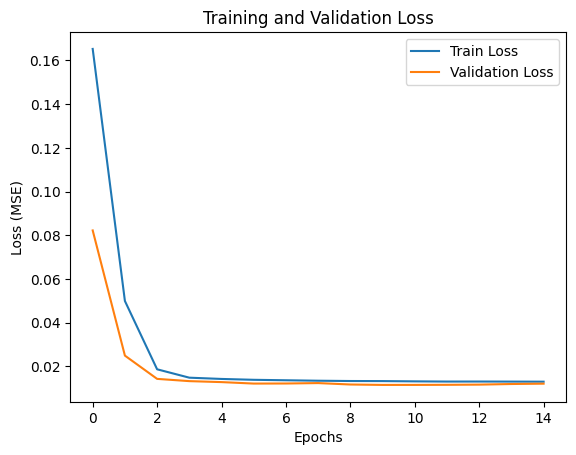

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2163 - mae: 0.2163 - val_loss: 0.0461 - val_mae: 0.0461
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 9/50
350/35

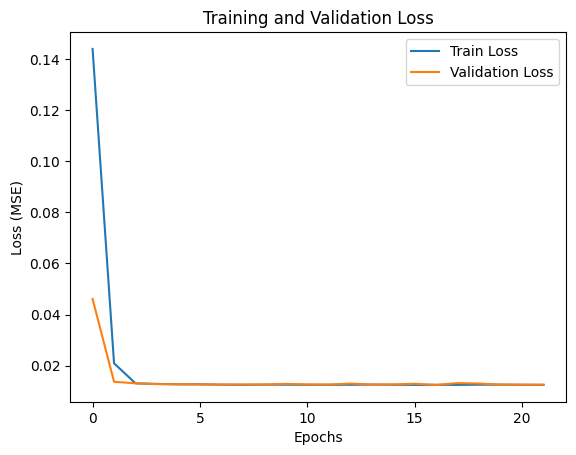

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Epoch 1/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4557 - mae: 0.4557 - val_loss: 0.0636 - val_mae: 0.0636
Epoch 2/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0591 - mae: 0.0591 - val_loss: 0.0212 - val_mae: 0.0212
Epoch 3/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 4/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 5/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 6/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 7/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 8/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 9/50
409/4

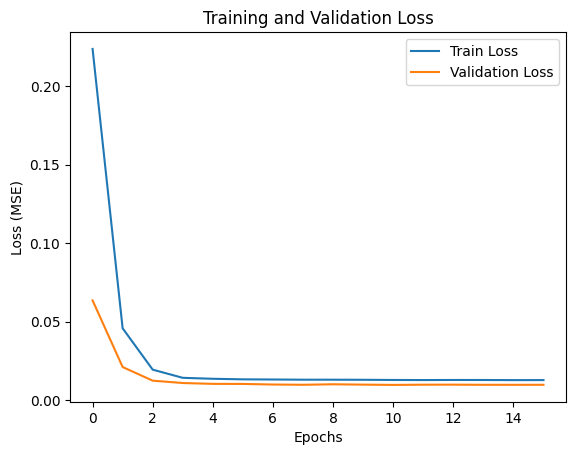

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1610 - mae: 0.1610 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 2/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 3/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 4/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 5/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 6/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 7/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 8/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 9/50
467/46

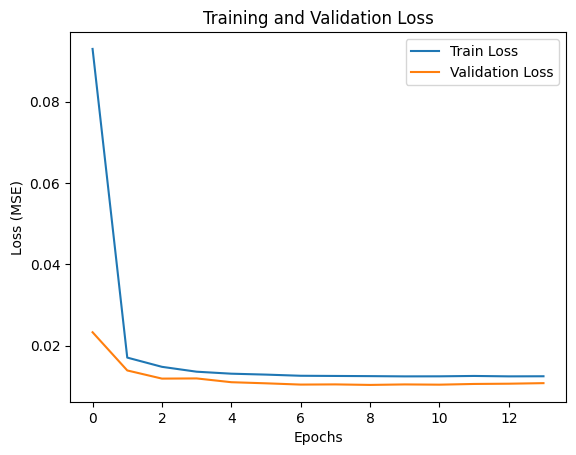

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1725 - mae: 0.1725 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 8/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 9/50
525/52

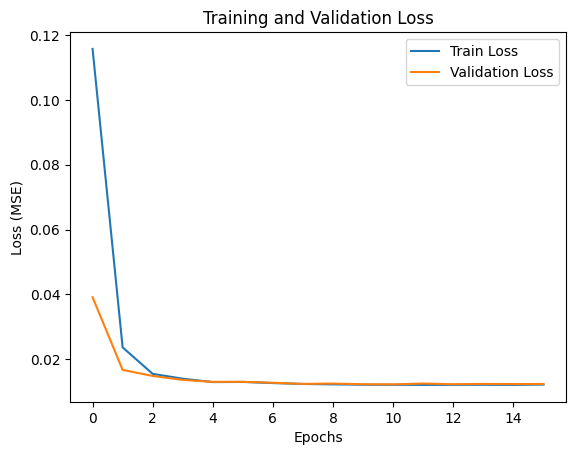

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1841 - mae: 0.1841 - val_loss: 0.0251 - val_mae: 0.0251
Epoch 2/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 3/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 4/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 5/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0123 - mae: 0.0123 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 6/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0122 - mae: 0.0122 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 7/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0159 - val_mae: 0.0159
Epoch 8/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 9/50
584/58

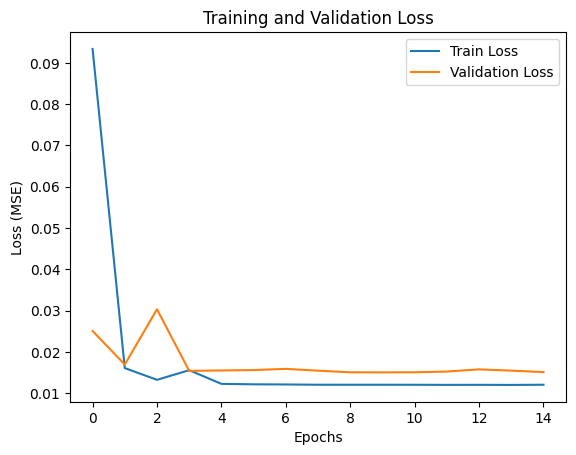

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0171 - val_mae: 0.0171
Epoch 6/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0171 - val_mae: 0.0171
Epoch 7/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 8/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 9/50
642/64

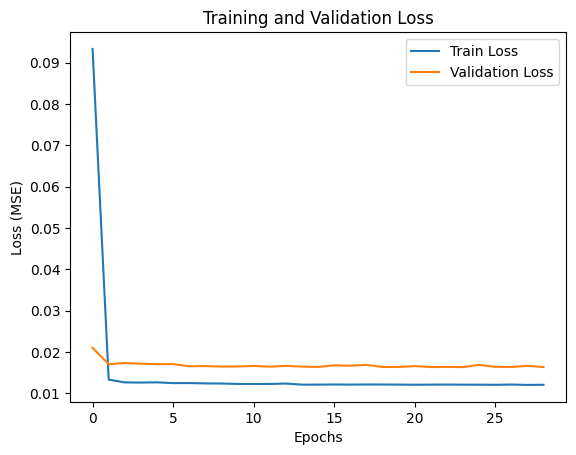

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1893 - mae: 0.1893 - val_loss: 0.0243 - val_mae: 0.0243
Epoch 2/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0194 - val_mae: 0.0194
Epoch 3/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 4/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 5/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 6/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0122 - mae: 0.0122 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 7/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0168 - val_mae: 0.0168
Epoch 8/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0122 - mae: 0.0122 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 9/50
700/70

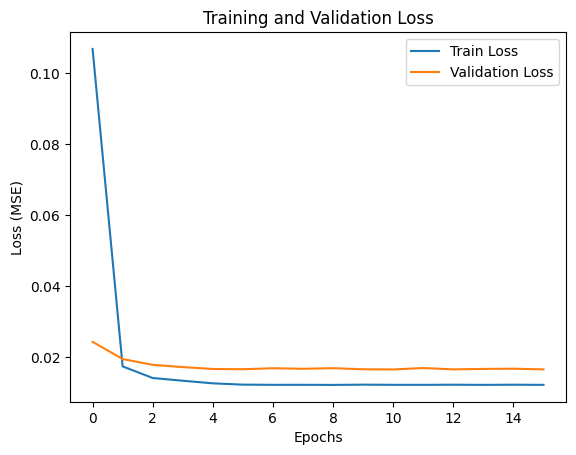

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2837 - mae: 0.2837 - val_loss: 0.0249 - val_mae: 0.0249
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0164 - val_mae: 0.0164
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 9/50
758/75

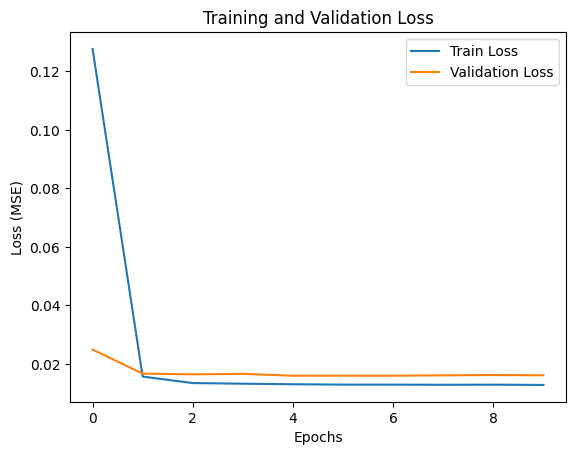

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1506 - mae: 0.1506 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 2/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 3/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 4/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 5/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 6/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 7/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 8/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 9/50
817/81

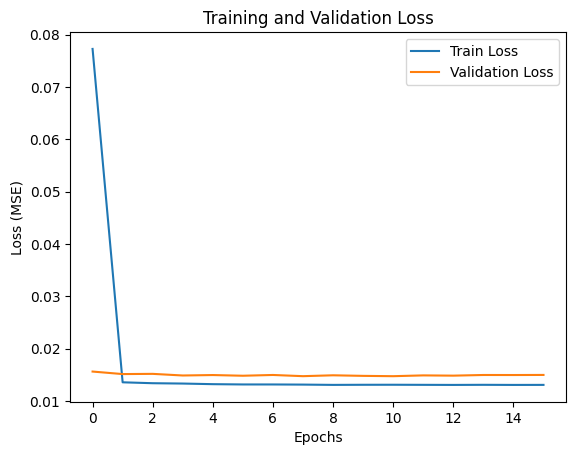

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.0003
RMSE: 0.0163
MAPE: 0.0115
MAE: 1.6219
R2: -0.1269
Correlation: 0.8649
Theil's U: 0.0125




In [129]:
lstm_metrics =[0]*7
for i in range(10):
    
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    # Define input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

    # Create the model
    model = create_unidirectional_lstm(input_shape=input_shape)

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Adjust as needed
        batch_size=128,  # Adjust as needed
        verbose=1,  # 1 shows progress after each epoch
        callbacks=[early_stopping]  # Include early stopping
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Predict returns for the validation set
    y_pred_1 = model.predict(X_test_1)

    y_pred_1 = y_pred_1.flatten()  # Flatten to 1D

    # Calculate metrics
    lstm_metrics[0] += mean_squared_error(y_test_1, y_pred_1)
    lstm_metrics[1] += np.sqrt(mean_squared_error(y_test_1, y_pred_1))
    lstm_metrics[2] += mean_absolute_error(y_test_1, y_pred_1)
    lstm_metrics[3] += mean_absolute_percentage_error(y_test_1, y_pred_1)
    lstm_metrics[4] += r2_score(y_test_1, y_pred_1)
    lstm_metrics[5] += theil_u(y_test_1, y_pred_1)
    lstm_metrics[6] += np.corrcoef(y_test_1, y_pred_1)[0, 1]

lstm_metrics = [metric / 10 for metric in lstm_metrics]

print_model_metrics(lstm_metrics)

y_pred_1 = y_pred_1.reshape(39, 20)

for i in range(len(list(data_dict[0].keys()))):
    final_lstm_preds[list(data_dict[0].keys())[i]] = y_pred_1[i]

##### Decision Tree Regressor

In [ ]:
X_test_1 = X_test_1.reshape(X_test_1.shape[0], -1)
dt_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)

    # Initialize the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=2)
    # Fit the model on the training data
    dt_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_dt = dt_regressor.predict(X_test_1)

    # Calculate metrics
    dt_metrics[0] += mean_squared_error(y_test_1, y_pred_dt)
    dt_metrics[1] += np.sqrt(mean_squared_error(y_test_1, y_pred_dt))
    dt_metrics[2] += mean_absolute_percentage_error(y_test_1, y_pred_dt)
    dt_metrics[3] += mean_absolute_error(y_test_1, y_pred_dt)
    dt_metrics[4] += r2_score(y_test_1, y_pred_dt)
    dt_metrics[5] += np.corrcoef(y_test_1, y_pred_dt)[0, 1]  # Correlation coefficient
    dt_metrics[6] += theil_u(y_test_1, y_pred_dt)

dt_metrics = [metric / 10 for metric in dt_metrics]

print_model_metrics(dt_metrics)

y_pred_dt = y_pred_dt.reshape(39, 20)

for i in range(len(list(data_dict[0].keys()))):
    final_dt_preds[list(data_dict[0].keys())[i]] = y_pred_dt[i]

# Compute feature importances
importances = dt_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_dt = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0008
RMSE: 0.0275
MAPE: 7.6065
MAE: 0.0196
R2: -2.2067
Correlation: -0.0247
Theil's U: 0.7282




##### Support Vector Regressor

In [132]:
svr_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)
    
    svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Fit the model on the training data
    svr_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_svr = svr_regressor.predict(X_test_1)

    # Calculate metrics
    svr_metrics[0] += mean_squared_error(y_test_1, y_pred_svr)
    svr_metrics[1] += np.sqrt(mean_squared_error(y_test_1, y_pred_svr))
    svr_metrics[2] += mean_absolute_percentage_error(y_test_1, y_pred_svr)
    svr_metrics[3] += mean_absolute_error(y_test_1, y_pred_svr)
    svr_metrics[4] += r2_score(y_test_1, y_pred_svr)
    svr_metrics[5] += np.corrcoef(y_test_1, y_pred_svr)[0, 1]  # Correlation coefficient
    svr_metrics[6] += theil_u(y_test_1, y_pred_svr)

svr_metrics = [metric / 10 for metric in svr_metrics]

print_model_metrics(svr_metrics)

y_pred_svr = y_pred_svr.reshape(39, 20)

for i in range(len(list(data_dict[0].keys()))):
    final_svr_preds[list(data_dict[0].keys())[i]] = y_pred_svr[i]

MSE: 0.0003
RMSE: 0.0174
MAPE: 3.0883
MAE: 0.0127
R2: -0.2700
Correlation: 0.0081
Theil's U: 0.7206




##### Random Forest Regressor

In [133]:
rf_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)    
    rf_regressor = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators= 25)

    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_rf = rf_regressor.predict(X_test_1)

    # Calculate metrics
    rf_metrics[0] += mean_squared_error(y_test_1, y_pred_rf)
    rf_metrics[1] += np.sqrt(mean_squared_error(y_test_1, y_pred_rf))
    rf_metrics[2] += mean_absolute_percentage_error(y_test_1, y_pred_rf)
    rf_metrics[3] += mean_absolute_error(y_test_1, y_pred_rf)
    rf_metrics[4] += r2_score(y_test_1, y_pred_rf)
    rf_metrics[5] += np.corrcoef(y_test_1, y_pred_rf)[0, 1]  # Correlation coefficient
    rf_metrics[6] += theil_u(y_test_1, y_pred_rf)

rf_metrics=[i/10 for i in rf_metrics]

print_model_metrics(rf_metrics)

y_pred_rf = y_pred_rf.reshape(39, 20)

for i in range(len(list(data_dict[0].keys()))):
    final_rf_preds[list(data_dict[0].keys())[i]] = y_pred_rf[i]

# Compute feature importances
importances = rf_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_rf = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0004
RMSE: 0.0194
MAPE: 4.3583
MAE: 0.0144
R2: -0.5961
Correlation: -0.0125
Theil's U: 0.7246




##### Feature Importance

In [134]:
print("Top 5 features for Decision Tree:")
for feature, importance in top_5_features_dt:
    print(f"{feature}: {importance:.4f}")
print("\nTop 5 features for Random Forest:")
for feature, importance in top_5_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 5 features for Decision Tree:
Exchange_Rate: 0.0326
Return_Lag_5: 0.0192
Daily_Return: 0.0147
WVAD: 0.0114
Return_Lag_4: 0.0114

Top 5 features for Random Forest:
Exchange_Rate: 0.0229
Return_Lag_5: 0.0217
ROC: 0.0129
SMI: 0.0107
MTM12: 0.0104


##### Cluster 1 - Model's Perfomance

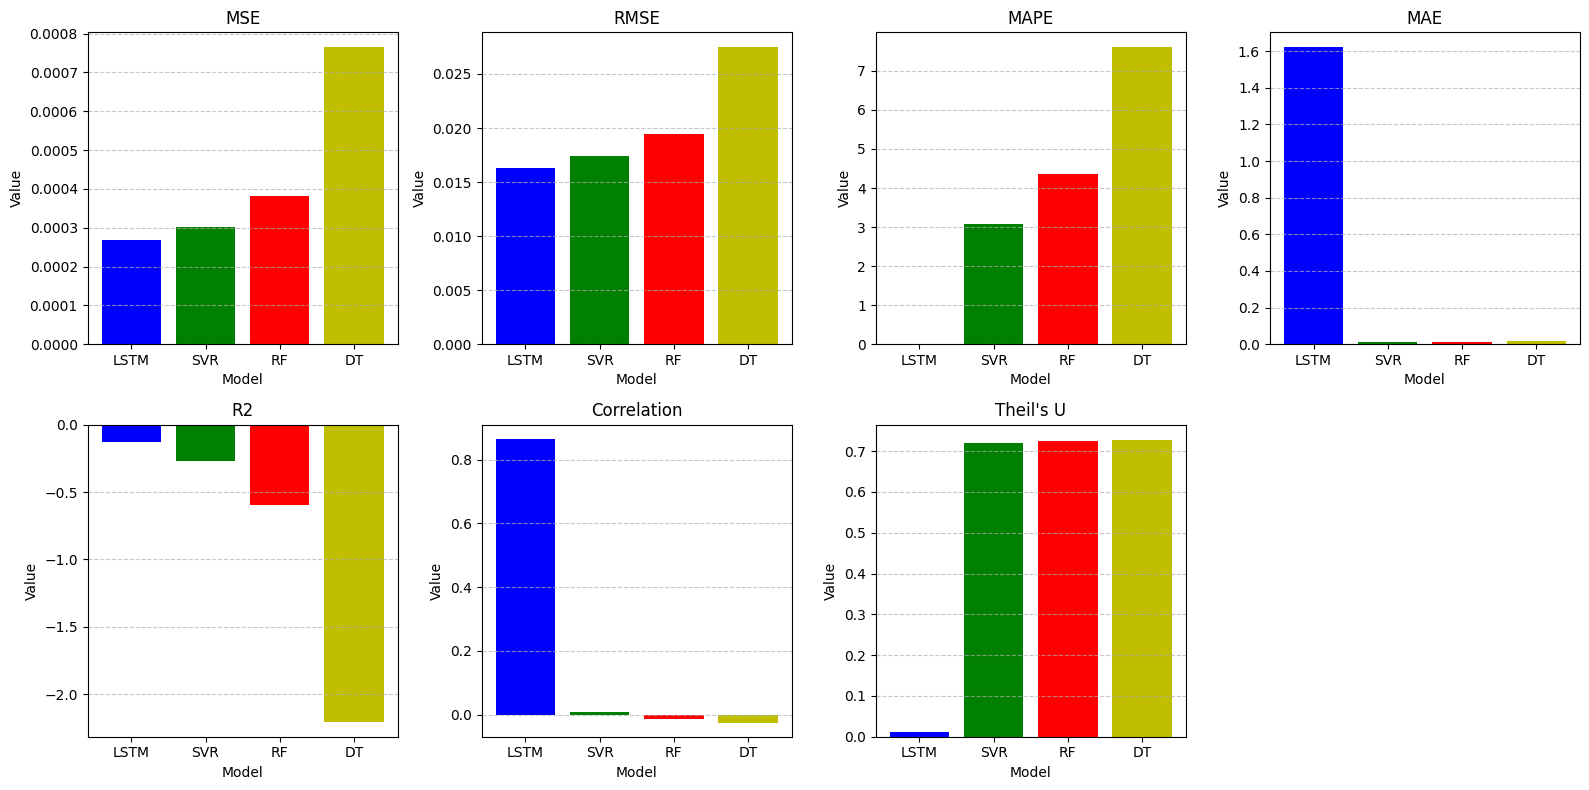

In [135]:
# Metrics for each model
metrics = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]

# Combine metrics into a single array for easier plotting
metrics_values = np.array([lstm_metrics, svr_metrics, rf_metrics, dt_metrics])
# Define data
models = ['LSTM', 'SVR', 'RF', 'DT']

# Create subplots: one for each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust rows/cols as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = metrics_values[:, i]
    ax.bar(models, values, color=['b', 'g', 'r', 'y'])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots (if metrics < 8 in this layout)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Cluster 2 (Eg: Warner Bros. Discovery, Delta Air Lines, Carnival Corporation)

- Medium/High Return
- High Volatility

In [136]:
cross_val_sets=[]
partition_sizes_list=[1168,1401, 1634, 1867, 2100, 2333, 2566, 2799, 3032, 3265]

for j in range(10):
    # Partition boundaries (replace with actual partition sizes)
    partition_sizes_start=[3250]*49
    partition_indices_start = np.cumsum([0] + partition_sizes_start)

    # Initialize storage for train and test splits
    X_train, X_val, y_train, y_val = [], [], [], []

    # Iterate over each partition
    for i in range(len(partition_sizes_start)):
        start_idx = partition_indices_start[i]
        end_idx=start_idx+partition_sizes_list[j]
    
        # Extract partition data
        X_partition = X_train_2[start_idx:end_idx]
        y_partition = y_train_2[start_idx:end_idx]
        
        # Split partition into train and test
        X_train_partition, X_val_partition, y_train_partition, y_val_partition = train_test_split(
            X_partition, y_partition, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Append to the overall train-test lists
        X_train.append(X_train_partition)
        X_val.append(X_val_partition)
        y_train.append(y_train_partition)
        y_val.append(y_val_partition)

    # Combine all partitions back into arrays
    X_train = np.concatenate(X_train)
    X_val = np.concatenate(X_val)
    y_train = np.concatenate(y_train)
    y_val = np.concatenate(y_val)
    cross_val_sets.append((X_train, X_val, y_train, y_val))


Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1886 - mae: 0.1886 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0150 - val_mae: 0.0150
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 9/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

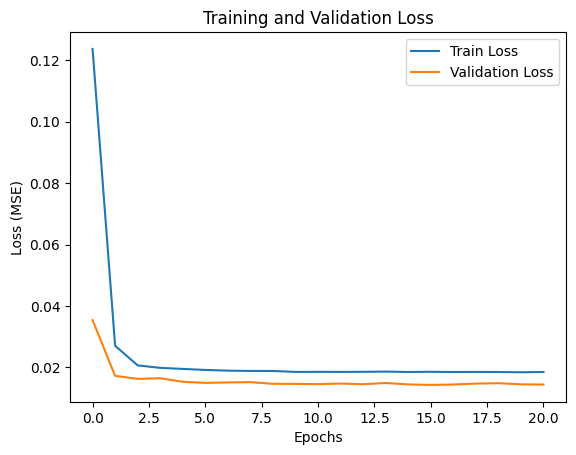

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1463 - mae: 0.1463 - val_loss: 0.0275 - val_mae: 0.0275
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 8/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 9/50
429/42

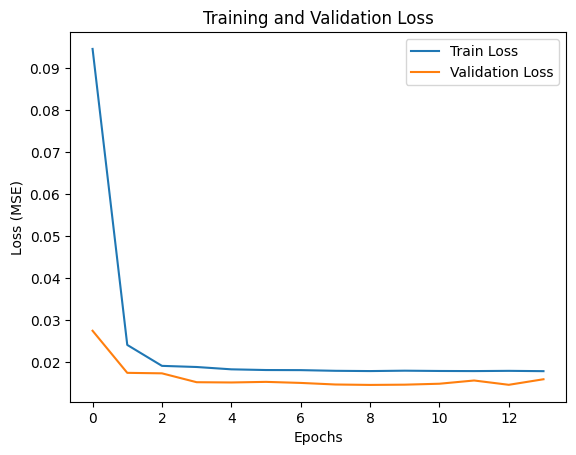

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2562 - mae: 0.2562 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 2/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 3/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0162 - val_mae: 0.0162
Epoch 4/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 5/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 6/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 7/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0162 - val_mae: 0.0162
Epoch 8/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 9/50
501/50

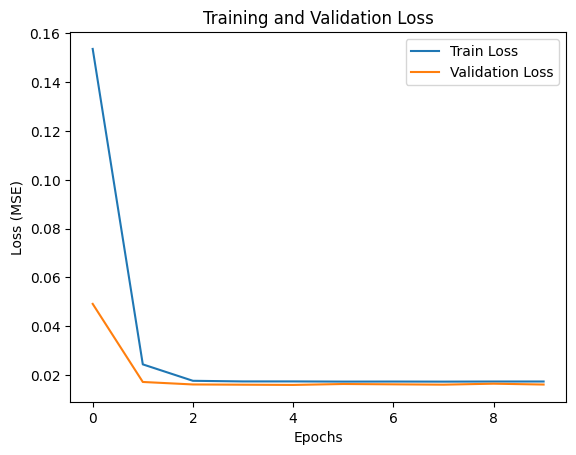

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1696 - mae: 0.1696 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 2/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 3/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 4/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 5/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 6/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0159 - val_mae: 0.0159
Epoch 7/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0162 - val_mae: 0.0162
Epoch 8/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 9/50
572/57

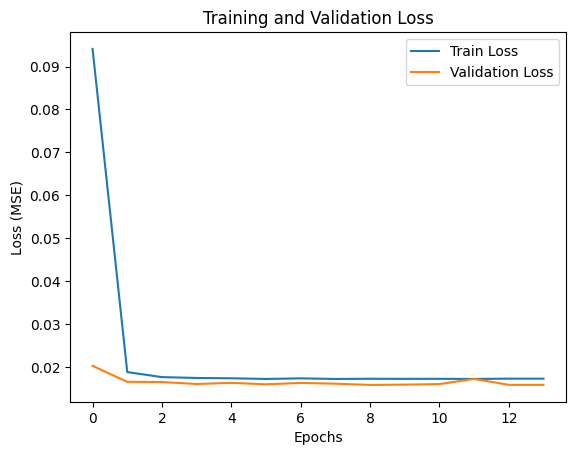

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.0225 - val_mae: 0.0225
Epoch 2/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 3/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 4/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 5/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 6/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 7/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 8/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 9/50
644/64

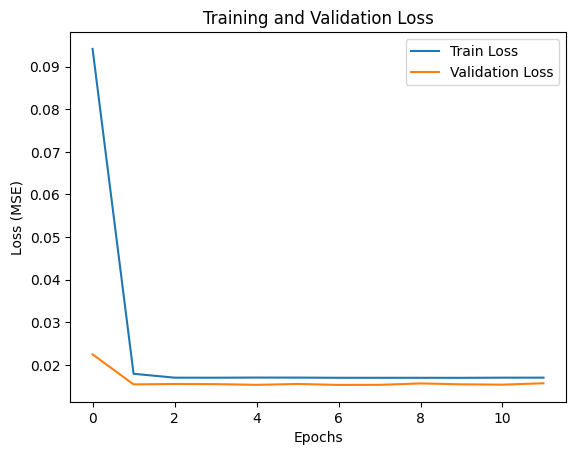

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
Epoch 1/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1580 - mae: 0.1580 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 2/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 3/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 4/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 5/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 6/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 7/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 8/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 9/50
715/7

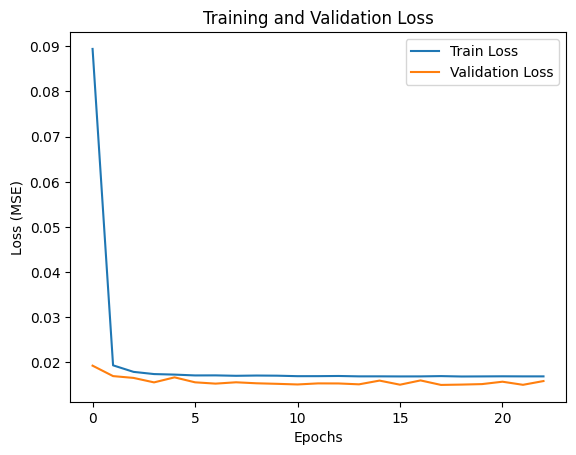

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1788 - mae: 0.1788 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 2/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 3/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 4/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0177 - val_mae: 0.0177
Epoch 5/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 6/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 7/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 8/50
786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 9/50
786/78

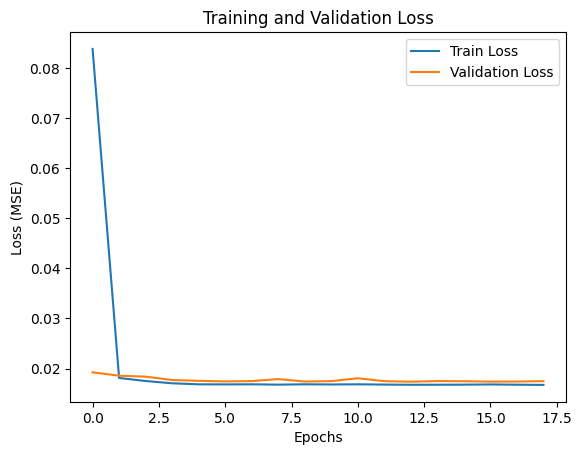

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1331 - mae: 0.1331 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0215 - val_mae: 0.0215
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0212 - val_mae: 0.0212


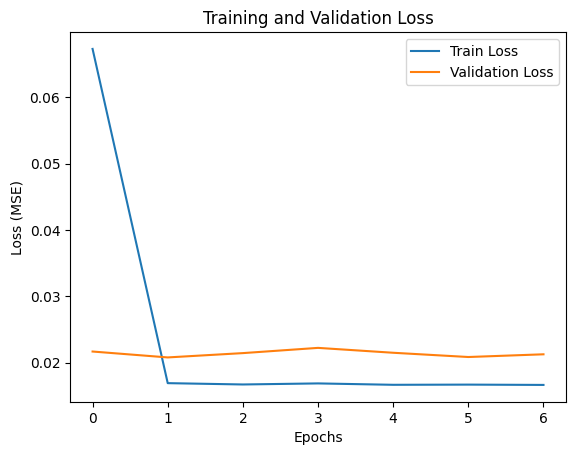

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1260 - mae: 0.1260 - val_loss: 0.0243 - val_mae: 0.0243
Epoch 2/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 3/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 4/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 5/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 6/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 7/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0236 - val_mae: 0.0236
Epoch 8/50
929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 9/50
929/92

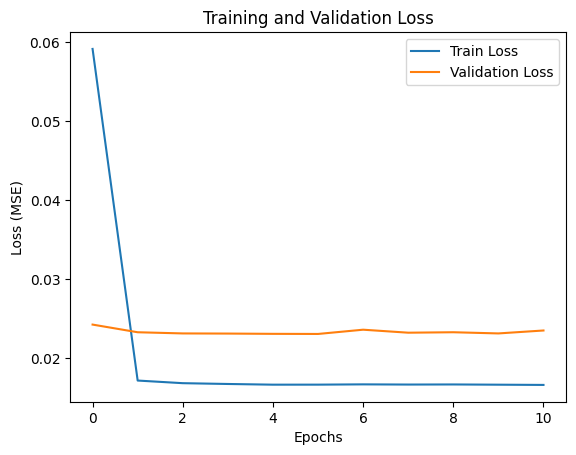

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1224 - mae: 0.1224 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0230 - val_mae: 0.0230
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0230 - val_mae: 0.0230
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0229 - val_mae: 0.0229
E

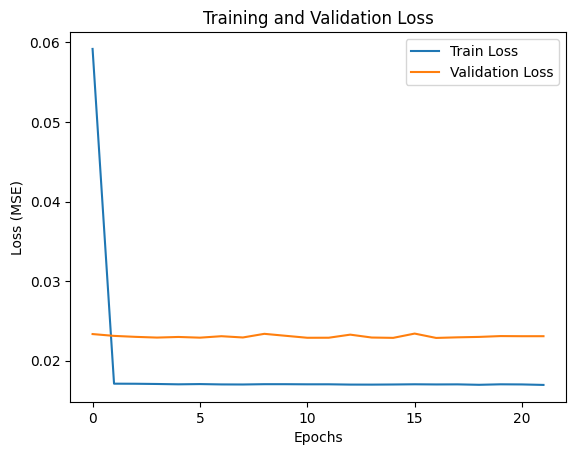

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.0004
RMSE: 0.0193
MAPE: 0.0147
MAE: 11590842813.6388
R2: -0.0201
Correlation: 0.9068
Theil's U: -0.0126




In [137]:
lstm_metrics=[0]*7
for i in range(10):
    
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    # Define input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

    # Create the model
    model = create_unidirectional_lstm(input_shape=input_shape)

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Adjust as needed
        batch_size=128,  # Adjust as needed
        verbose=1,  # 1 shows progress after each epoch
        callbacks=[early_stopping]  # Include early stopping
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Predict returns for the validation set
    y_pred_2 = model.predict(X_test_2)

    y_pred_2 = y_pred_2.flatten()  # Flatten to 1D

    # Calculate metrics
    lstm_metrics[0] += mean_squared_error(y_test_2, y_pred_2)
    lstm_metrics[1] += np.sqrt(mean_squared_error(y_test_2, y_pred_2))
    lstm_metrics[2] += mean_absolute_error(y_test_2, y_pred_2)
    lstm_metrics[3] += mean_absolute_percentage_error(y_test_2, y_pred_2)
    lstm_metrics[4] += r2_score(y_test_2, y_pred_2)
    lstm_metrics[5] += theil_u(y_test_2, y_pred_2)
    lstm_metrics[6] += np.corrcoef(y_test_2, y_pred_2)[0, 1]

lstm_metrics = [metric / 10 for metric in lstm_metrics]

print_model_metrics(lstm_metrics)

y_pred_2 = y_pred_2.reshape(47, 20)

for i in range(len(list(data_dict[1].keys()))):
    final_lstm_preds[list(data_dict[1].keys())[i]] = y_pred_2[i]

##### Decision Tree Regressor

In [138]:
X_test_2 = X_test_2.reshape(X_test_2.shape[0], -1)
dt_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)

    # Initialize the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=2)

    # Fit the model on the training data
    dt_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_dt = dt_regressor.predict(X_test_2)

    # Calculate metrics
    dt_metrics[0] += mean_squared_error(y_test_2, y_pred_dt)
    dt_metrics[1] += np.sqrt(mean_squared_error(y_test_2, y_pred_dt))
    dt_metrics[2] += mean_absolute_percentage_error(y_test_2, y_pred_dt)
    dt_metrics[3] += mean_absolute_error(y_test_2, y_pred_dt)
    dt_metrics[4] += r2_score(y_test_2, y_pred_dt)
    dt_metrics[5] += np.corrcoef(y_test_2, y_pred_dt)[0, 1]  # Correlation coefficient
    dt_metrics[6] += theil_u(y_test_2, y_pred_dt)

dt_metrics = [metric / 10 for metric in dt_metrics]

print_model_metrics(dt_metrics)

y_pred_dt = y_pred_dt.reshape(47, 20)

for i in range(len(list(data_dict[1].keys()))):
    final_dt_preds[list(data_dict[1].keys())[i]] = y_pred_dt[i]

# Compute feature importances
importances = dt_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_dt = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0012
RMSE: 0.0344
MAPE: 114614098894.9771
MAE: 0.0264
R2: -2.2470
Correlation: -0.0108
Theil's U: 0.7319




##### Support Vector Regressor

In [139]:
svr_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)
    
    svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Fit the model on the training data
    svr_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_svr = svr_regressor.predict(X_test_2)

    # Calculate metrics
    svr_metrics[0] += mean_squared_error(y_test_2, y_pred_svr)
    svr_metrics[1] += np.sqrt(mean_squared_error(y_test_2, y_pred_svr))
    svr_metrics[2] += mean_absolute_percentage_error(y_test_2, y_pred_svr)
    svr_metrics[3] += mean_absolute_error(y_test_2, y_pred_svr)
    svr_metrics[4] += r2_score(y_test_2, y_pred_svr)
    svr_metrics[5] += np.corrcoef(y_test_2, y_pred_svr)[0, 1]  # Correlation coefficient
    svr_metrics[6] += theil_u(y_test_2, y_pred_svr)

svr_metrics = [metric / 10 for metric in svr_metrics]

print_model_metrics(svr_metrics)

y_pred_svr = y_pred_svr.reshape(47, 20)

for i in range(len(list(data_dict[1].keys()))):
    final_svr_preds[list(data_dict[1].keys())[i]] = y_pred_svr[i]

MSE: 0.0006
RMSE: 0.0238
MAPE: 54828806958.7862
MAE: 0.0179
R2: -0.5550
Correlation: -0.0348
Theil's U: 0.7352




##### Random Forest Regressor

In [140]:
rf_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)    
    rf_regressor = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators= 25)

    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_rf = rf_regressor.predict(X_test_2)

    # Calculate metrics
    rf_metrics[0] += mean_squared_error(y_test_2, y_pred_rf)
    rf_metrics[1] += np.sqrt(mean_squared_error(y_test_2, y_pred_rf))
    rf_metrics[2] += mean_absolute_percentage_error(y_test_2, y_pred_rf)
    rf_metrics[3] += mean_absolute_error(y_test_2, y_pred_rf)
    rf_metrics[4] += r2_score(y_test_2, y_pred_rf)
    rf_metrics[5] += np.corrcoef(y_test_2, y_pred_rf)[0, 1]  # Correlation coefficient
    rf_metrics[6] += theil_u(y_test_2, y_pred_rf)

rf_metrics=[i/10 for i in rf_metrics]

print_model_metrics(rf_metrics)

y_pred_rf = y_pred_rf.reshape(47, 20)

for i in range(len(list(data_dict[1].keys()))):
    final_rf_preds[list(data_dict[1].keys())[i]] = y_pred_rf[i]

# Compute feature importances
importances = rf_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_rf = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0007
RMSE: 0.0260
MAPE: 87375070305.1088
MAE: 0.0203
R2: -0.8748
Correlation: 0.0038
Theil's U: 0.7219




##### Feature Importance

In [141]:
print("Top 5 features for Decision Tree:")
for feature, importance in top_5_features_dt:
    print(f"{feature}: {importance:.4f}")
print("\nTop 5 features for Random Forest:")
for feature, importance in top_5_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 5 features for Decision Tree:
Exchange_Rate: 0.0301
Return_Lag_5: 0.0218
Return_Lag_4: 0.0119
ROC: 0.0114
WVAD: 0.0107

Top 5 features for Random Forest:
Exchange_Rate: 0.0273
Return_Lag_5: 0.0247
WVAD: 0.0139
ROC: 0.0131
Return_Lag_4: 0.0113


##### Cluster 2 - Model's Perfomance

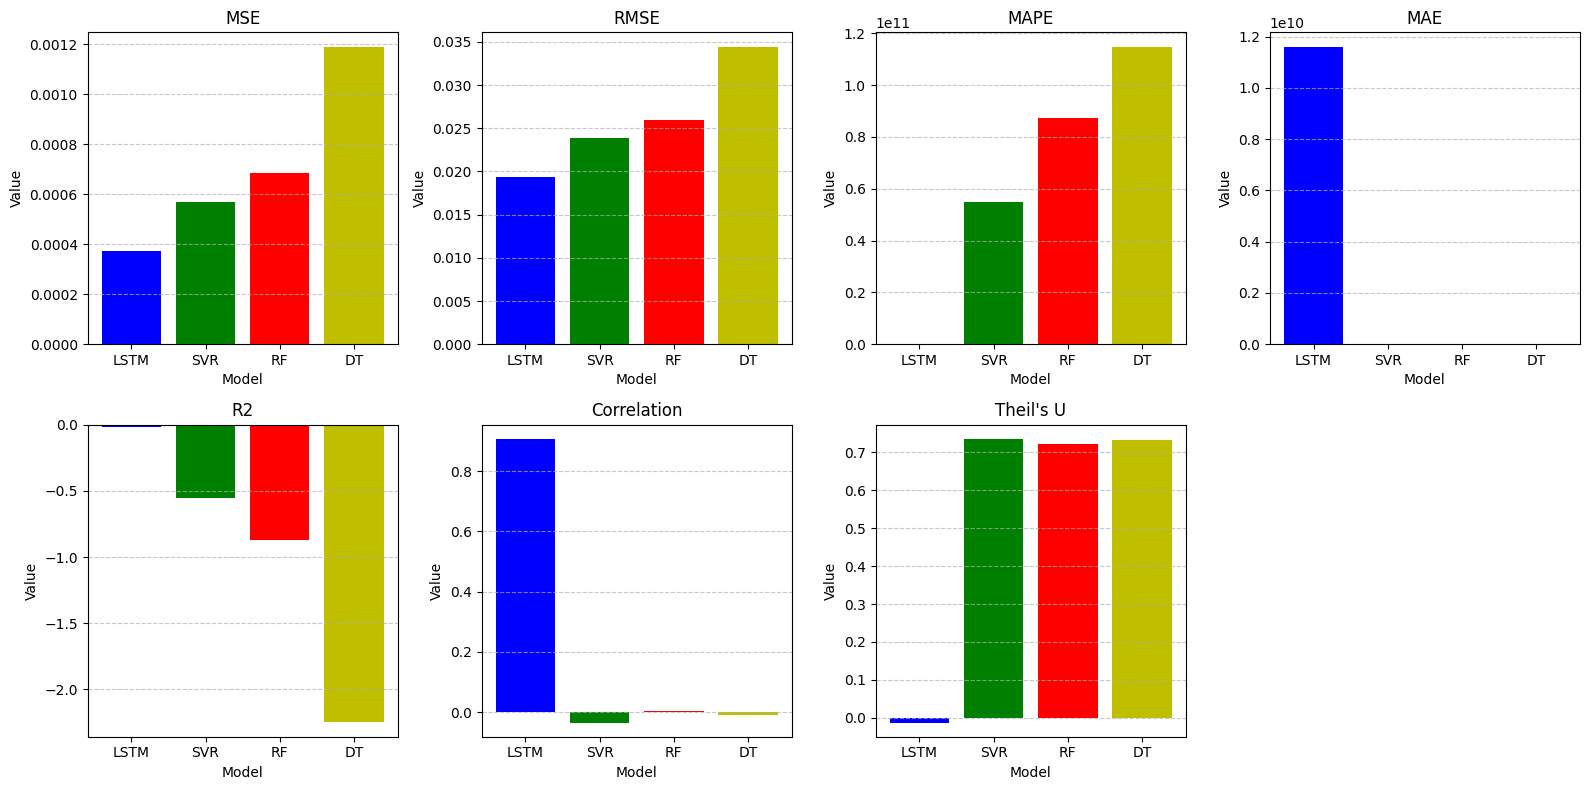

In [142]:
# Metrics for each model
metrics = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]

# Combine metrics into a single array for easier plotting
metrics_values = np.array([lstm_metrics, svr_metrics, rf_metrics, dt_metrics])
# Define data
models = ['LSTM', 'SVR', 'RF', 'DT']

# Create subplots: one for each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust rows/cols as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = metrics_values[:, i]
    ax.bar(models, values, color=['b', 'g', 'r', 'y'])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots (if metrics < 8 in this layout)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Cluster 3 (eg: Netflix, Nvidia)

- Rapid Growth
- High Return
- High Volatility

In [143]:
cross_val_sets=[]
partition_sizes_list=[1168,1401, 1634, 1867, 2100, 2333, 2566, 2799, 3032, 3265]

for j in range(10):
    # Partition boundaries (replace with actual partition sizes)
    partition_sizes_start=[3250]*14
    partition_indices_start = np.cumsum([0] + partition_sizes_start)

    # Initialize storage for train and test splits
    X_train, X_val, y_train, y_val = [], [], [], []

    # Iterate over each partition
    for i in range(len(partition_sizes_start)):
        start_idx = partition_indices_start[i]
        end_idx=start_idx+partition_sizes_list[j]
    
        # Extract partition data
        X_partition = X_train_3[start_idx:end_idx]
        y_partition = y_train_3[start_idx:end_idx]
        
        # Split partition into train and test
        X_train_partition, X_val_partition, y_train_partition, y_val_partition = train_test_split(
            X_partition, y_partition, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Append to the overall train-test lists
        X_train.append(X_train_partition)
        X_val.append(X_val_partition)
        y_train.append(y_train_partition)
        y_val.append(y_val_partition)

    # Combine all partitions back into arrays
    X_train = np.concatenate(X_train)
    X_val = np.concatenate(X_val)
    y_train = np.concatenate(y_train)
    y_val = np.concatenate(y_val)
    cross_val_sets.append((X_train, X_val, y_train, y_val))


Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4387 - mae: 0.4387 - val_loss: 0.2081 - val_mae: 0.2081
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1939 - mae: 0.1939 - val_loss: 0.1298 - val_mae: 0.1298
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1198 - mae: 0.1198 - val_loss: 0.0963 - val_mae: 0.0963
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0857 - mae: 0.0857 - val_loss: 0.0597 - val_mae: 0.0597
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 - mae: 0.0572 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0286 - val_mae: 0.0286
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0165 - val_mae: 0.0165
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

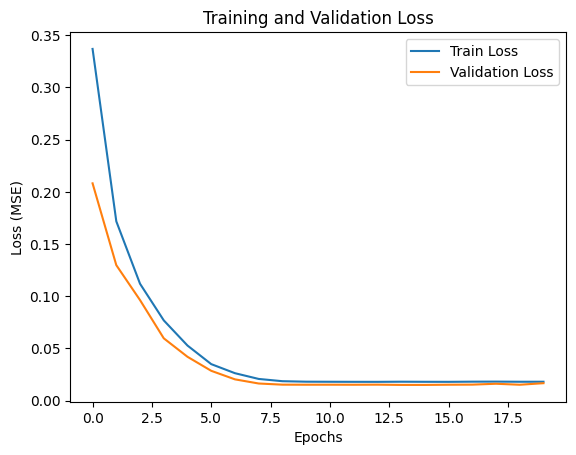

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5497 - mae: 0.5497 - val_loss: 0.2284 - val_mae: 0.2284
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1997 - mae: 0.1997 - val_loss: 0.1593 - val_mae: 0.1593
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1390 - mae: 0.1390 - val_loss: 0.1135 - val_mae: 0.1135
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1048 - mae: 0.1048 - val_loss: 0.0781 - val_mae: 0.0781
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0701 - mae: 0.0701 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - mae: 0.0542 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0265 - val_mae: 0.0265
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0215 - val_mae: 0.0215
Epoch 9/50
123/123

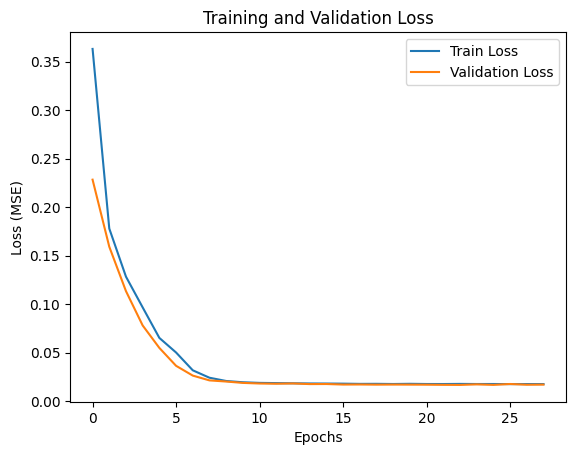

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1899 - mae: 0.1899 - val_loss: 0.1140 - val_mae: 0.1140
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0617 - val_mae: 0.0617
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0526 - mae: 0.0526 - val_loss: 0.0302 - val_mae: 0.0302
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 9/50
143/143 

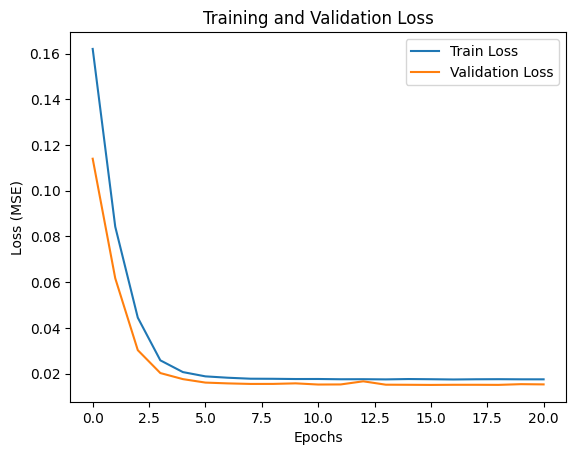

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3537 - mae: 0.3537 - val_loss: 0.1685 - val_mae: 0.1685
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.0876 - val_mae: 0.0876
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0766 - mae: 0.0766 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0220 - val_mae: 0.0220
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 9/50
164/164

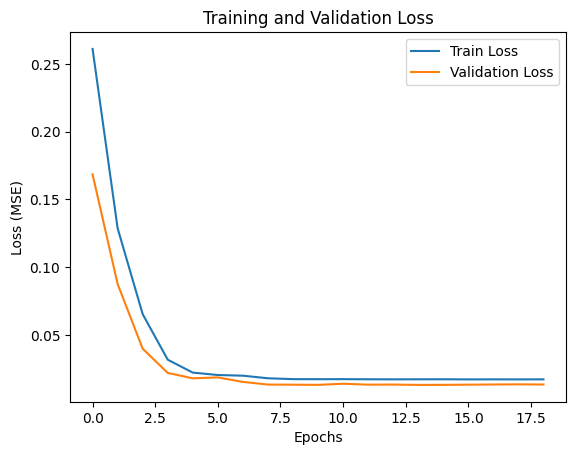

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2528 - mae: 0.2528 - val_loss: 0.1209 - val_mae: 0.1209
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1088 - mae: 0.1088 - val_loss: 0.0556 - val_mae: 0.0556
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0484 - mae: 0.0484 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0171 - val_mae: 0.0171
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 9/50
184/184

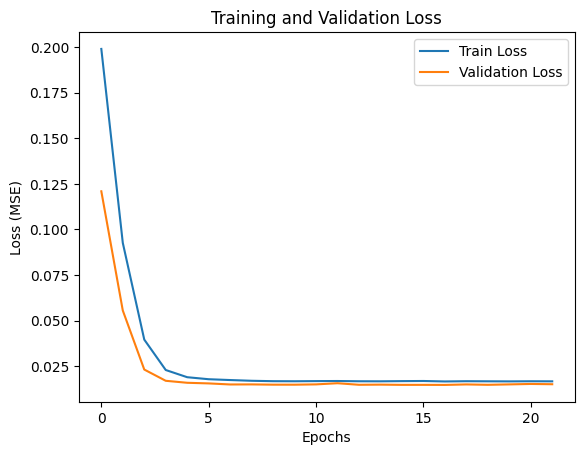

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3236 - mae: 0.3236 - val_loss: 0.1402 - val_mae: 0.1402
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1226 - mae: 0.1226 - val_loss: 0.0614 - val_mae: 0.0614
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0507 - mae: 0.0507 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0237 - val_mae: 0.0237
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 9/50
205/205

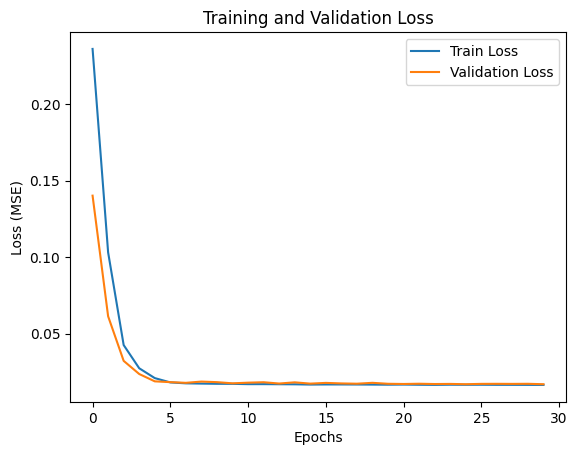

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2041 - mae: 0.2041 - val_loss: 0.1061 - val_mae: 0.1061
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0887 - mae: 0.0887 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0261 - val_mae: 0.0261
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0234 - val_mae: 0.0234
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0221 - val_mae: 0.0221
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 9/50
225/225

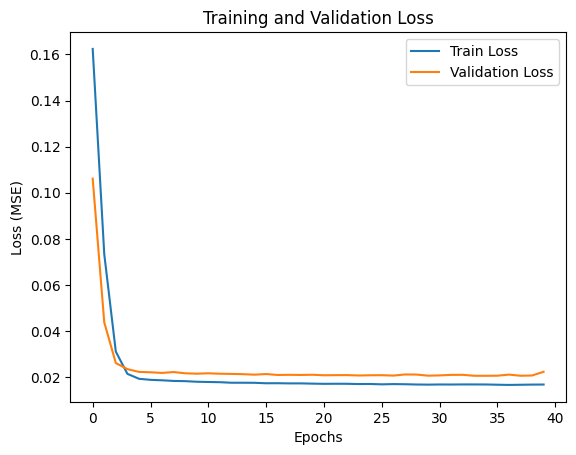

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2724 - mae: 0.2724 - val_loss: 0.0981 - val_mae: 0.0981
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0236 - val_mae: 0.0236
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 9/50
245/245

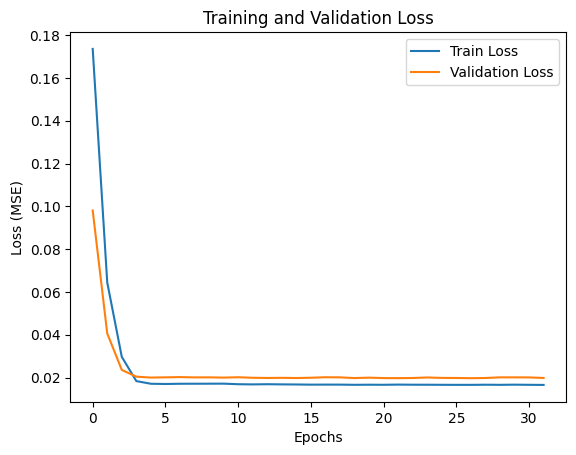

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2183 - mae: 0.2183 - val_loss: 0.0796 - val_mae: 0.0796
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0613 - mae: 0.0613 - val_loss: 0.0297 - val_mae: 0.0297
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0215 - val_mae: 0.0215
Epoch 5/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 6/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 7/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 8/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0213 - val_mae: 0.0213
Epoch 9/50
266/266

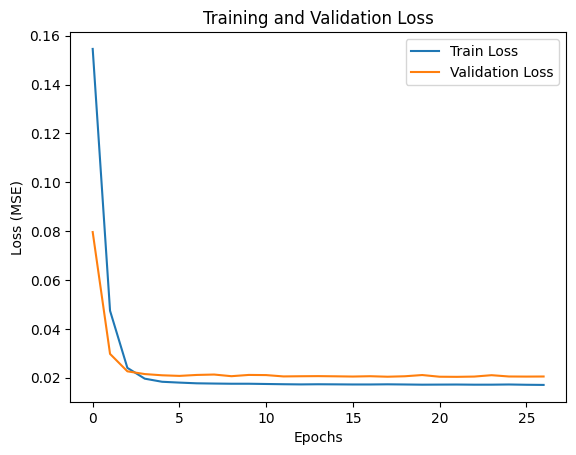

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2852 - mae: 0.2852 - val_loss: 0.1018 - val_mae: 0.1018
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0775 - mae: 0.0775 - val_loss: 0.0269 - val_mae: 0.0269
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0203 - val_mae: 0.0203
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0199 - val_mae: 0.0199
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 9/50
286/286

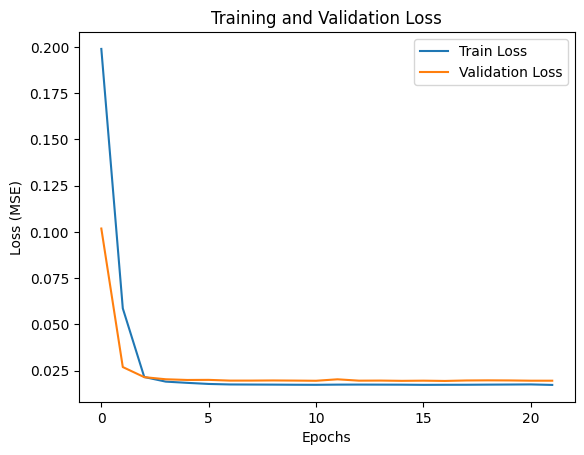

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 0.0004
RMSE: 0.0210
MAPE: 1.3677
MAE: 0.0145
R2: -0.0216
Correlation: 0.0001
Theil's U: 0.8811




In [144]:
lstm_metrics=[0]*7
for i in range(10):
    
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    # Define input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

    # Create the model
    model = create_unidirectional_lstm(input_shape=input_shape)

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Adjust as needed
        batch_size=128,  # Adjust as needed
        verbose=1,  # 1 shows progress after each epoch
        callbacks=[early_stopping]  # Include early stopping
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Predict returns for the validation set
    y_pred_3 = model.predict(X_test_3)

    y_pred_3 = y_pred_3.flatten()  # Flatten to 1D

    # Calculate metrics
    lstm_metrics[0] += mean_squared_error(y_test_3, y_pred_3)
    lstm_metrics[1] += np.sqrt(mean_squared_error(y_test_3, y_pred_3))
    lstm_metrics[2] += mean_absolute_percentage_error(y_test_3, y_pred_3)
    lstm_metrics[3] += mean_absolute_error(y_test_3, y_pred_3)
    lstm_metrics[4] += r2_score(y_test_3, y_pred_3)
    lstm_metrics[5] += np.corrcoef(y_test_3, y_pred_3)[0, 1]  # Correlation coefficient
    lstm_metrics[6] += theil_u(y_test_3, y_pred_3)

lstm_metrics = [metric / 10 for metric in lstm_metrics]

print_model_metrics(lstm_metrics)

y_pred_3 = y_pred_3.reshape(13, 20)

for i in range(len(list(data_dict[2].keys()))):
    final_lstm_preds[list(data_dict[2].keys())[i]] = y_pred_3[i]

##### Decision Tree Regressor

In [ ]:
X_test_3 = X_test_3.reshape(X_test_3.shape[0], -1)
dt_metrics = [0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)

    # Initialize the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=2)

    # Fit the model on the training data
    dt_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_dt = dt_regressor.predict(X_test_3)

    # Calculate metrics
    dt_metrics[0]+= mean_squared_error(y_test_3, y_pred_dt)
    dt_metrics[1]+= np.sqrt(mean_squared_error(y_test_3, y_pred_dt))
    dt_metrics[2]+= mean_absolute_percentage_error(y_test_3, y_pred_dt)
    dt_metrics[3]+= mean_absolute_error(y_test_3, y_pred_dt)
    dt_metrics[4]+= r2_score(y_test_3, y_pred_dt)
    dt_metrics[5]+= np.corrcoef(y_test_3, y_pred_dt)[0, 1]  # Correlation coefficient
    dt_metrics[6]+= theil_u(y_test_3, y_pred_dt)

dt_metrics=[x/10 for x in dt_metrics]

print_model_metrics(dt_metrics)

y_pred_dt = y_pred_dt.reshape(13, 20)

for i in range(len(list(data_dict[2].keys()))):
    final_dt_preds[list(data_dict[2].keys())[i]] = y_pred_dt[i]

# Compute feature importances
importances = dt_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_dt = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0014
RMSE: 0.0361
MAPE: 7.1178
MAE: 0.0272
R2: -2.1983
Correlation: 0.0281
Theil's U: 0.7077




##### Support Vector Regressor

In [146]:
svr_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)
    
    svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Fit the model on the training data
    svr_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_svr = svr_regressor.predict(X_test_3)

    # Calculate metrics

    svr_metrics[0] += mean_squared_error(y_test_3, y_pred_svr)
    svr_metrics[1] += np.sqrt(mean_squared_error(y_test_3, y_pred_svr))
    svr_metrics[2] += mean_absolute_percentage_error(y_test_3, y_pred_svr)
    svr_metrics[3] += mean_absolute_error(y_test_3, y_pred_svr)
    svr_metrics[4] += r2_score(y_test_3, y_pred_svr)
    svr_metrics[5] += np.corrcoef(y_test_3, y_pred_svr)[0, 1]  # Correlation coefficient
    svr_metrics[6] += theil_u(y_test_3, y_pred_svr)

svr_metrics=[x/10 for x in svr_metrics]

print_model_metrics(svr_metrics)

y_pred_svr = y_pred_svr.reshape(13, 20)

for i in range(len(list(data_dict[2].keys()))):
    final_svr_preds[list(data_dict[2].keys())[i]] = y_pred_svr[i]

MSE: 0.0005
RMSE: 0.0214
MAPE: 2.7058
MAE: 0.0016
R2: -0.0051
Correlation: 0.0085
Theil's U: 0.0718




##### Random Forest Regressor

In [147]:
rf_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)    
    rf_regressor = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators= 25)

    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_rf = rf_regressor.predict(X_test_3)

    # Calculate metrics
    rf_metrics[0] += mean_squared_error(y_test_3, y_pred_rf)
    rf_metrics[1] += np.sqrt(mean_squared_error(y_test_3, y_pred_rf))
    rf_metrics[2] += mean_absolute_percentage_error(y_test_3, y_pred_rf)
    rf_metrics[3] += mean_absolute_error(y_test_3, y_pred_rf)
    rf_metrics[4] += r2_score(y_test_3, y_pred_rf)
    rf_metrics[5] += np.corrcoef(y_test_3, y_pred_rf)[0, 1]  # Correlation coefficient
    rf_metrics[6] += theil_u(y_test_3, y_pred_rf)
    

rf_metrics=[x/10 for x in rf_metrics]

print_model_metrics(rf_metrics)

y_pred_rf = y_pred_rf.reshape(13, 20)

for i in range(len(list(data_dict[2].keys()))):
    final_rf_preds[list(data_dict[2].keys())[i]] = y_pred_rf[i]

# Compute feature importances
importances = rf_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_rf = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0006
RMSE: 0.0251
MAPE: 3.5924
MAE: 0.0019
R2: -0.0558
Correlation: -0.0017
Theil's U: 0.0731




##### Feature Importance

In [148]:
print("Top 5 features for Decision Tree:")
for feature, importance in top_5_features_dt:
    print(f"{feature}: {importance:.4f}")
print("\nTop 5 features for Random Forest:")
for feature, importance in top_5_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 5 features for Decision Tree:
Return_Lag_5: 0.0218
Exchange_Rate: 0.0186
SMI: 0.0149
Return_Lag_3: 0.0144
Return_Lag_4: 0.0128

Top 5 features for Random Forest:
Return_Lag_5: 0.0254
ROC: 0.0144
Return_Lag_3: 0.0142
WVAD: 0.0120
MTM6: 0.0118


##### Cluster 3 - Model's Performance

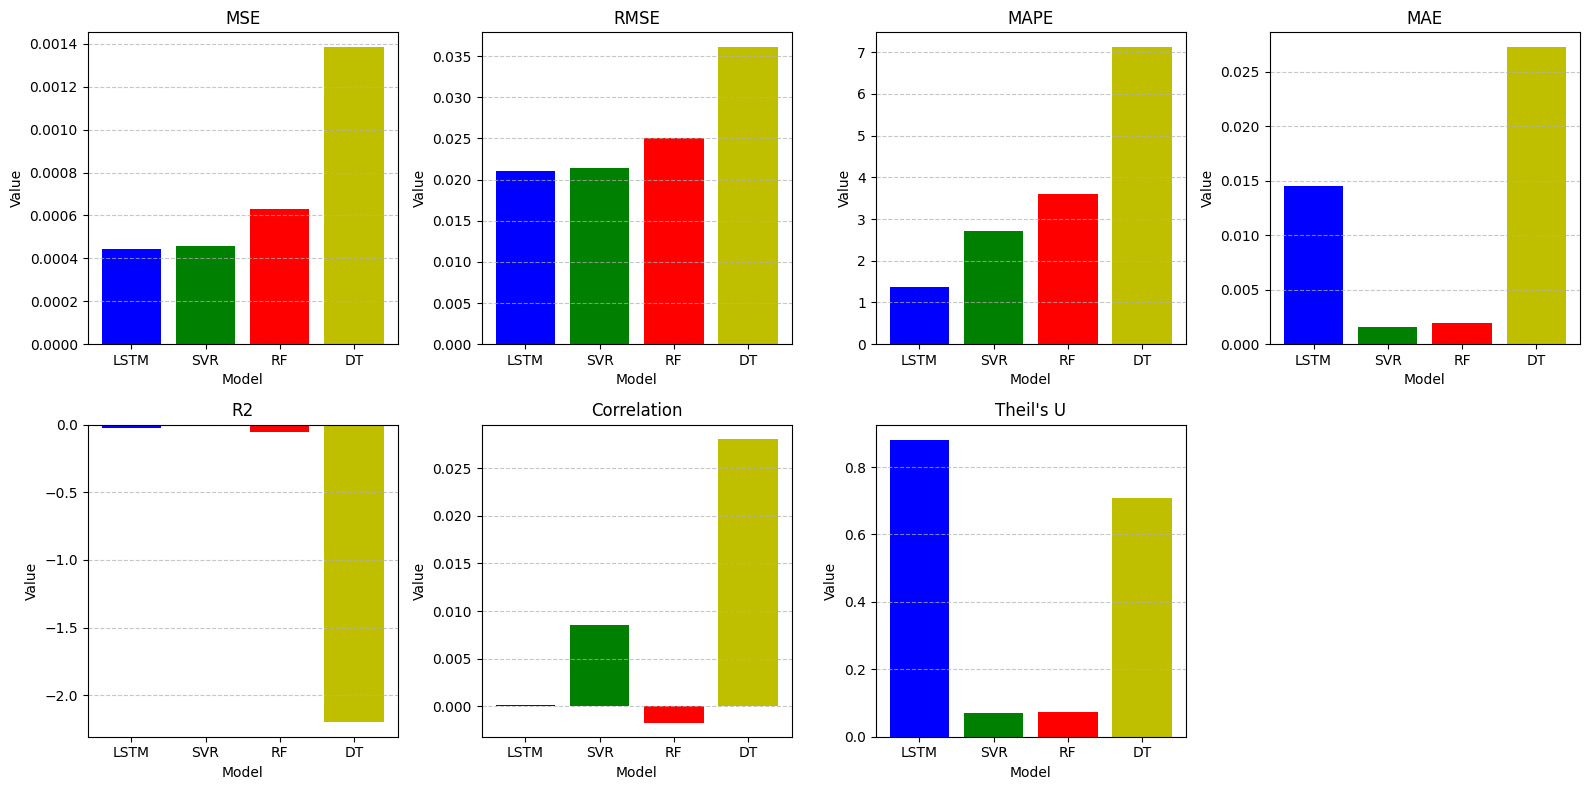

In [149]:
# Metrics for each model
metrics = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]

# Combine metrics into a single array for easier plotting
metrics_values = np.array([lstm_metrics, svr_metrics, rf_metrics, dt_metrics])
# Define data
models = ['LSTM', 'SVR', 'RF', 'DT']

# Create subplots: one for each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust rows/cols as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = metrics_values[:, i]
    ax.bar(models, values, color=['b', 'g', 'r', 'y'])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots (if metrics < 8 in this layout)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Cluster 4 (eg: Coca-Cola, McDonald's, Walmart)

- Stablished Companies
- Very Low Volatility
- Medium Return

In [150]:
cross_val_sets=[]
partition_sizes_list=[1168,1401, 1634, 1867, 2100, 2333, 2566, 2799, 3032, 3265]

for j in range(10):
    # Partition boundaries (replace with actual partition sizes)
    partition_sizes_start=[3250]*185
    partition_indices_start = np.cumsum([0] + partition_sizes_start)

    # Initialize storage for train and test splits
    X_train, X_val, y_train, y_val = [], [], [], []

    # Iterate over each partition
    for i in range(len(partition_sizes_start)):
        start_idx = partition_indices_start[i]
        end_idx=start_idx+partition_sizes_list[j]
    
        # Extract partition data
        X_partition = X_train_4[start_idx:end_idx]
        y_partition = y_train_4[start_idx:end_idx]
        
        # Split partition into train and test
        X_train_partition, X_val_partition, y_train_partition, y_val_partition = train_test_split(
            X_partition, y_partition, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Append to the overall train-test lists
        X_train.append(X_train_partition)
        X_val.append(X_val_partition)
        y_train.append(y_train_partition)
        y_val.append(y_val_partition)

    # Combine all partitions back into arrays
    X_train = np.concatenate(X_train)
    X_val = np.concatenate(X_val)
    y_train = np.concatenate(y_train)
    y_val = np.concatenate(y_val)
    cross_val_sets.append((X_train, X_val, y_train, y_val))

Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1283 - mae: 0.1283 - val_loss: 0.0115 - val_mae: 0.0115
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0108 - val_mae: 0.0108
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 9/50
1350/1350 ━━━━━━━━━━━━━━━━━━━

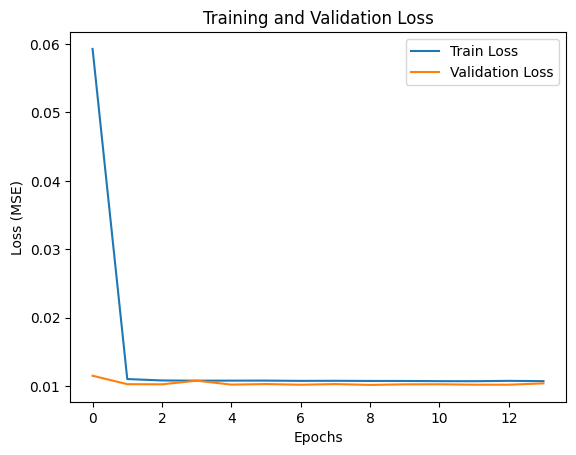

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Epoch 1/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1238 - mae: 0.1238 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 2/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 3/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 4/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0120 - mae: 0.0120 - val_loss: 0.0112 - val_mae: 0.0112
Epoch 5/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 6/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 7/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 8/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0118 - val_mae: 0.01

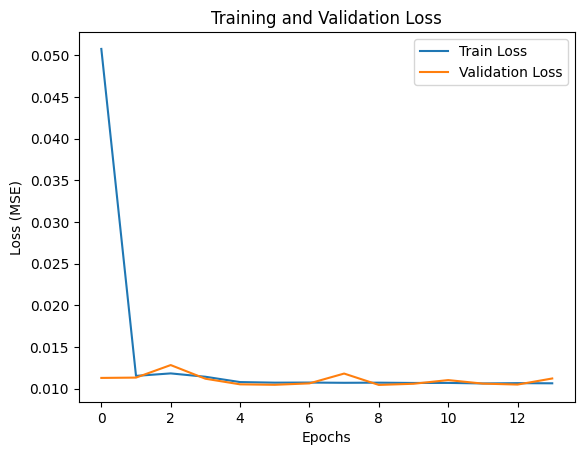

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1173 - mae: 0.1173 - val_loss: 0.0108 - val_mae: 0.0108
Epoch 2/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 3/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 4/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 5/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0112 - val_mae: 0.0112
Epoch 6/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 7/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 8/50
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0106 - val_mae: 0.0106

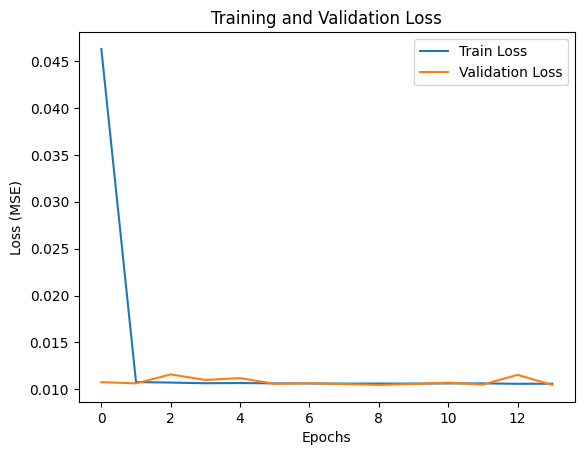

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
Epoch 1/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0967 - mae: 0.0967 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 2/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0115 - val_mae: 0.0115
Epoch 3/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0109 - val_mae: 0.0109
Epoch 4/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0111 - mae: 0.0111 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 5/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0110 - mae: 0.0110 - val_loss: 0.0112 - val_mae: 0.0112
Epoch 6/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 7/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 8/50
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0106 - val_mae: 0.01

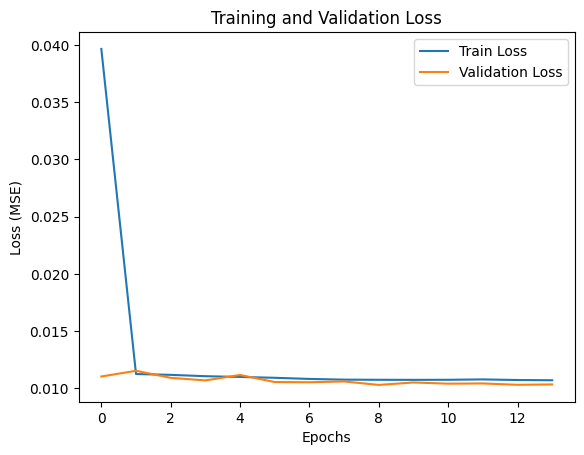

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1724 - mae: 0.1724 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 2/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 3/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 4/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 5/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 6/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 7/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 8/50
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0099 - val_mae: 0.009

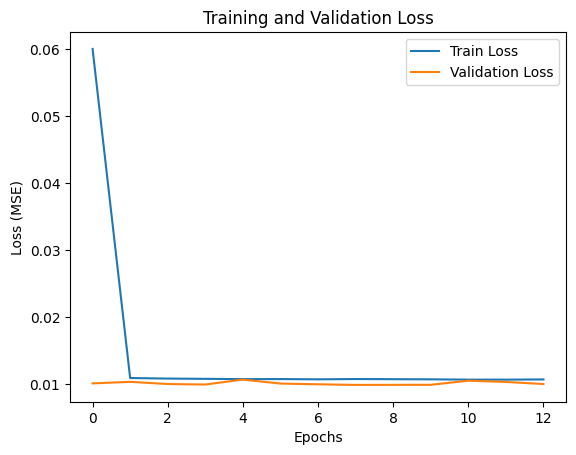

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 2/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 3/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 4/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 5/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 6/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 7/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 8/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0098 - val_mae: 0.00

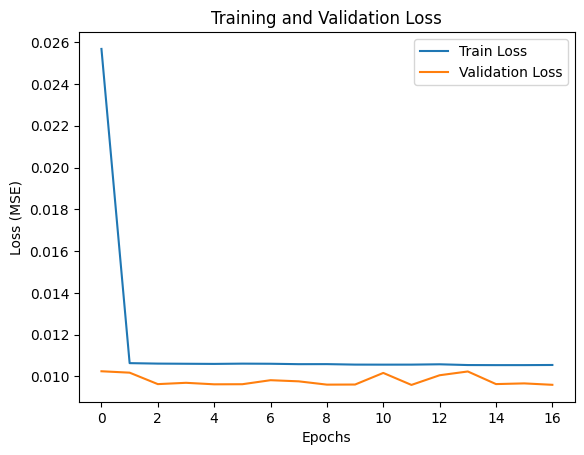

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0642 - mae: 0.0642 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 2/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 3/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 4/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 5/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 6/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 7/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 8/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0098 - val_mae: 0.

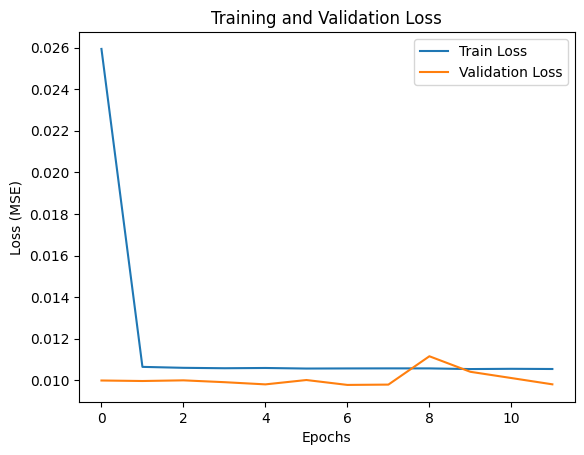

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0744 - mae: 0.0744 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 2/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 3/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 4/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 5/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 6/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 7/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 8/50
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0102 - val_ma

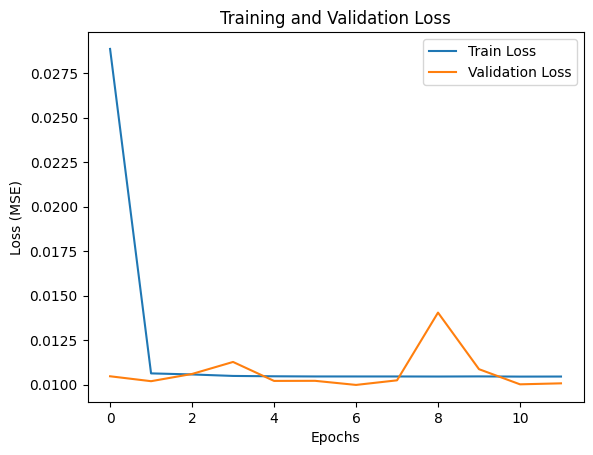

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0757 - mae: 0.0757 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 2/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0111 - mae: 0.0111 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 3/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 4/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 5/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 6/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 7/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 8/50
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0101 - val_mae

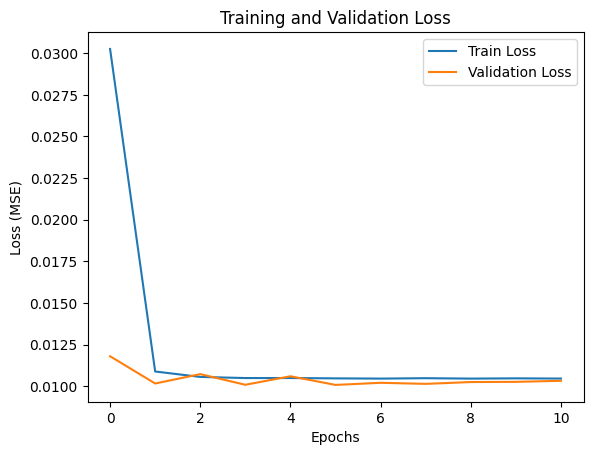

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0592 - mae: 0.0592 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 2/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 3/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 4/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 5/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 6/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 7/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 8/50
3776/3776 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0101 - val_mae

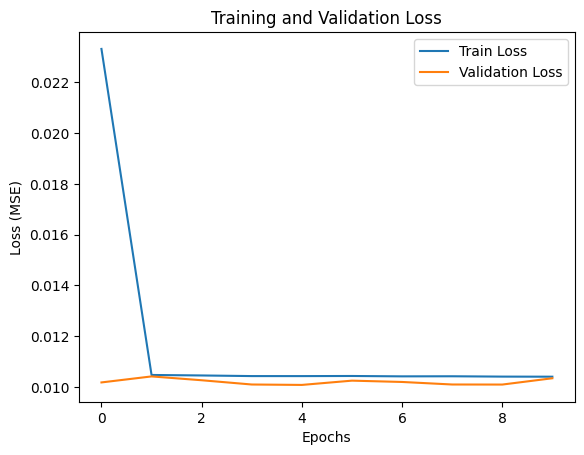

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.0002
RMSE: 0.0300
MAPE: 18365559989.0258
MAE: 0.0092
R2: -0.0058
Correlation: 0.0088
Theil's U: 0.9163




In [151]:
lstm_metrics=[0]*7
for i in range(10):
    
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    # Define input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

    # Create the model
    model = create_unidirectional_lstm(input_shape=input_shape)

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Adjust as needed
        batch_size=128,  # Adjust as needed
        verbose=1,  # 1 shows progress after each epoch
        callbacks=[early_stopping]  # Include early stopping
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Predict returns for the validation set
    y_pred_4 = model.predict(X_test_4)

    y_pred_4 = y_pred_4.flatten()  # Flatten to 1D

    # Calculate metrics
    lstm_metrics[0] += mean_squared_error(y_test_4, y_pred_4)
    lstm_metrics[1] += np.sqrt(lstm_metrics[0])
    lstm_metrics[2] += mean_absolute_percentage_error(y_test_4, y_pred_4)
    lstm_metrics[3] += mean_absolute_error(y_test_4, y_pred_4)
    lstm_metrics[4] += r2_score(y_test_4, y_pred_4)
    lstm_metrics[5] += np.corrcoef(y_test_4, y_pred_4)[0, 1]  # Correlation coefficient
    lstm_metrics[6] += theil_u(y_test_4, y_pred_4)

lstm_metrics = [metric / 10 for metric in lstm_metrics]

print_model_metrics(lstm_metrics)

y_pred_4 = y_pred_4.reshape(184, 20)

for i in range(len(list(data_dict[3].keys()))):
    final_lstm_preds[list(data_dict[3].keys())[i]] = y_pred_4[i]

##### Decision Tree Regressor

In [152]:
X_test_4 = X_test_4.reshape(X_test_4.shape[0], -1)
dt_metrics = [0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)

    # Initialize the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=2)

    # Fit the model on the training data
    dt_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_dt = dt_regressor.predict(X_test_4)

    # Calculate metrics
    dt_metrics[0]+= mean_squared_error(y_test_4, y_pred_dt)
    dt_metrics[1]+= np.sqrt(mean_squared_error(y_test_4, y_pred_dt))
    dt_metrics[2]+= mean_absolute_percentage_error(y_test_4, y_pred_dt)
    dt_metrics[3]+= mean_absolute_error(y_test_4, y_pred_dt)
    dt_metrics[4]+= r2_score(y_test_4, y_pred_dt)
    dt_metrics[5]+= np.corrcoef(y_test_4, y_pred_dt)[0, 1]  # Correlation coefficient
    dt_metrics[6]+= theil_u(y_test_4, y_pred_dt)

dt_metrics=[x/10 for x in dt_metrics]

print_model_metrics(dt_metrics)

y_pred_dt = y_pred_dt.reshape(184, 20)

for i in range(len(list(data_dict[3].keys()))):
    final_dt_preds[list(data_dict[3].keys())[i]] = y_pred_dt[i]

# Compute feature importances
importances = dt_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_dt = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0010
RMSE: 0.0301
MAPE: 433448378724.4119
MAE: 0.0213
R2: -4.5761
Correlation: -0.0123
Theil's U: 0.7482




##### Support Vector Regressor

In [153]:
svr_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)
    
    svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Fit the model on the training data
    svr_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_svr = svr_regressor.predict(X_test_4)

    # Calculate metrics
    svr_metrics[0] += mean_squared_error(y_test_4, y_pred_svr)
    svr_metrics[1] += np.sqrt(mean_squared_error(y_test_4, y_pred_svr))
    svr_metrics[2] += mean_absolute_percentage_error(y_test_4, y_pred_svr)
    svr_metrics[3] += mean_absolute_error(y_test_4, y_pred_svr)
    svr_metrics[4] += r2_score(y_test_4, y_pred_svr)
    svr_metrics[5] += np.corrcoef(y_test_4, y_pred_svr)[0, 1]  # Correlation coefficient
    svr_metrics[6] += theil_u(y_test_4, y_pred_svr)

svr_metrics=[x/10 for x in svr_metrics]

print_model_metrics(svr_metrics)

y_pred_svr = y_pred_svr.reshape(184, 20)

for i in range(len(list(data_dict[3].keys()))):
    final_svr_preds[list(data_dict[3].keys())[i]] = y_pred_svr[i]

MSE: 0.0003
RMSE: 0.0185
MAPE: 177039228049.7502
MAE: 0.0014
R2: -0.0964
Correlation: -0.0007
Theil's U: 0.0711




##### Random Forest Regressor

In [ ]:
rf_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)    
    rf_regressor = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators= 25)
    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_rf = rf_regressor.predict(X_test_4)

    # Calculate metrics
    rf_metrics[0] += mean_squared_error(y_test_4, y_pred_rf)
    rf_metrics[1] += np.sqrt(mean_squared_error(y_test_4, y_pred_rf))
    rf_metrics[2] += mean_absolute_percentage_error(y_test_4, y_pred_rf)
    rf_metrics[3] += mean_absolute_error(y_test_4, y_pred_rf)
    rf_metrics[4] += r2_score(y_test_4, y_pred_rf)
    rf_metrics[5] += np.corrcoef(y_test_4, y_pred_rf)[0, 1]  # Correlation coefficient
    rf_metrics[6] += theil_u(y_test_4, y_pred_rf)

rf_metrics=[x/10 for x in rf_metrics]

print_model_metrics(rf_metrics)

y_pred_rf = y_pred_rf.reshape(184, 20)

for i in range(len(list(data_dict[3].keys()))):
    final_rf_preds[list(data_dict[3].keys())[i]] = y_pred_rf[i]

# Compute feature importances
importances = rf_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_rf = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0003
RMSE: 0.0165
MAPE: 172169135580.4843
MAE: 0.0012
R2: -0.0383
Correlation: 0.0076
Theil's U: 0.0692




##### Feature Importance

In [155]:
print("Top 5 features for Decision Tree:")
for feature, importance in top_5_features_dt:
    print(f"{feature}: {importance:.4f}")
print("\nTop 5 features for Random Forest:")
for feature, importance in top_5_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 5 features for Decision Tree:
Exchange_Rate: 0.0373
Return_Lag_5: 0.0184
Return_Lag_3: 0.0170
Return_Lag_4: 0.0154
Daily_Return: 0.0111

Top 5 features for Random Forest:
Exchange_Rate: 0.0418
Return_Lag_5: 0.0187
Return_Lag_4: 0.0129
WVAD: 0.0099
ROC: 0.0099


##### Cluster 4 - Model's Performance

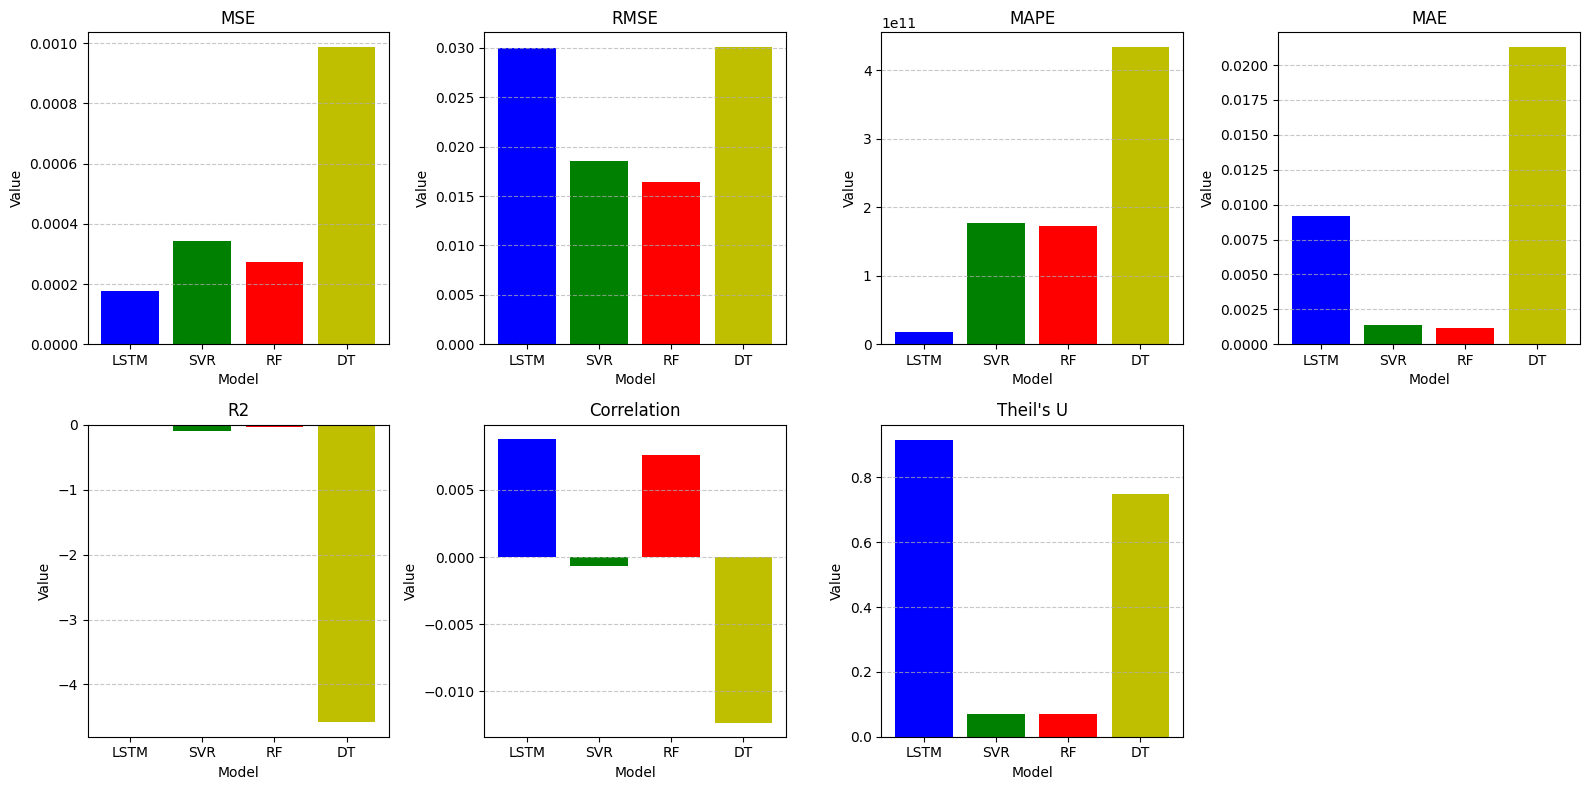

In [156]:
# Metrics for each model
metrics = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]

# Combine metrics into a single array for easier plotting
metrics_values = np.array([lstm_metrics, svr_metrics, rf_metrics, dt_metrics])
# Define data
models = ['LSTM', 'SVR', 'RF', 'DT']

# Create subplots: one for each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust rows/cols as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = metrics_values[:, i]
    ax.bar(models, values, color=['b', 'g', 'r', 'y'])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots (if metrics < 8 in this layout)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Cluster 5 (eg: American Express, Boeing, Goldman Sachs)

- Higher Volatility
- Medium Return

In [157]:
cross_val_sets=[]
partition_sizes_list=[1168,1401, 1634, 1867, 2100, 2333, 2566, 2799, 3032, 3265]

for j in range(10):
    # Partition boundaries (replace with actual partition sizes)
    partition_sizes_start=[3250]*128
    partition_indices_start = np.cumsum([0] + partition_sizes_start)

    # Initialize storage for train and test splits
    X_train, X_val, y_train, y_val = [], [], [], []

    # Iterate over each partition
    for i in range(len(partition_sizes_start)):
        start_idx = partition_indices_start[i]
        end_idx=start_idx+partition_sizes_list[j]
    
        # Extract partition data
        X_partition = X_train_5[start_idx:end_idx]
        y_partition = y_train_5[start_idx:end_idx]
        
        # Split partition into train and test
        X_train_partition, X_val_partition, y_train_partition, y_val_partition = train_test_split(
            X_partition, y_partition, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Append to the overall train-test lists
        X_train.append(X_train_partition)
        X_val.append(X_val_partition)
        y_train.append(y_train_partition)
        y_val.append(y_val_partition)

    # Combine all partitions back into arrays
    X_train = np.concatenate(X_train)
    X_val = np.concatenate(X_val)
    y_train = np.concatenate(y_train)
    y_val = np.concatenate(y_val)
    cross_val_sets.append((X_train, X_val, y_train, y_val))

Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1217 - mae: 0.1217 - val_loss: 0.0164 - val_mae: 0.0164
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 9/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

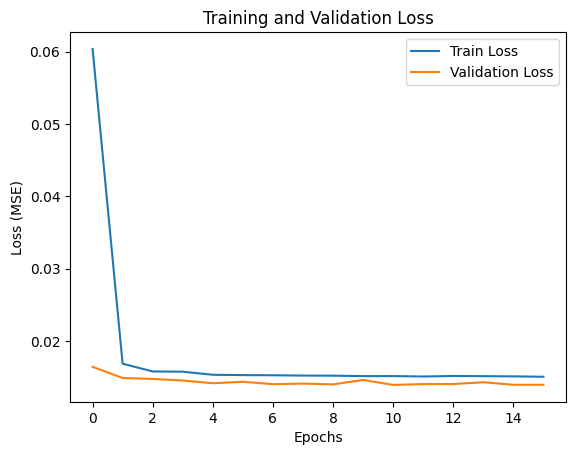

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1163 - mae: 0.1163 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 2/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0163 - mae: 0.0163 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 3/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 4/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 5/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 6/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 7/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 8/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0133 - val_mae: 0.0133
E

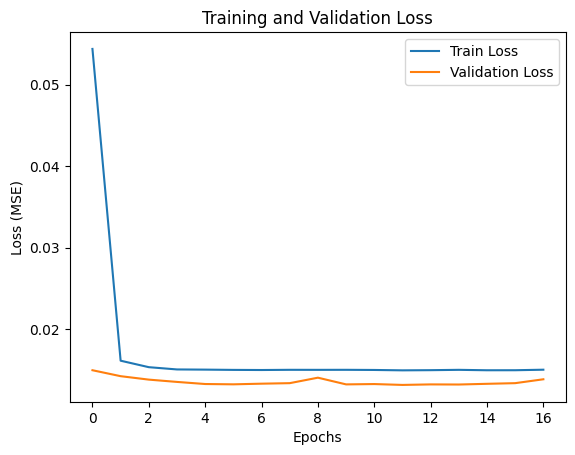

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0968 - mae: 0.0968 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 2/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 3/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 4/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 5/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 6/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 7/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 8/50
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0136 - val_mae: 0.0136


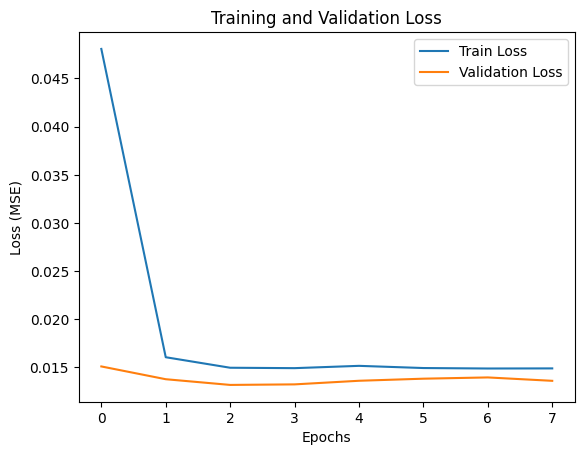

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1134 - mae: 0.1134 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 2/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 3/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 4/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 5/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 6/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 7/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 8/50
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0137 - val_mae: 0.0137


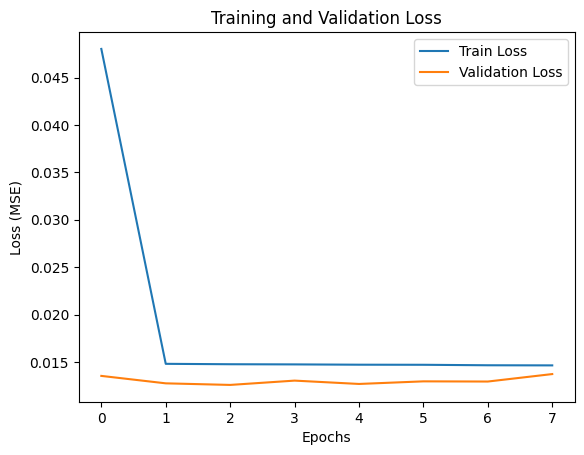

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0946 - mae: 0.0946 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 2/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 3/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 4/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 5/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 6/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 7/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 8/50
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0120 - val_mae: 0.0120


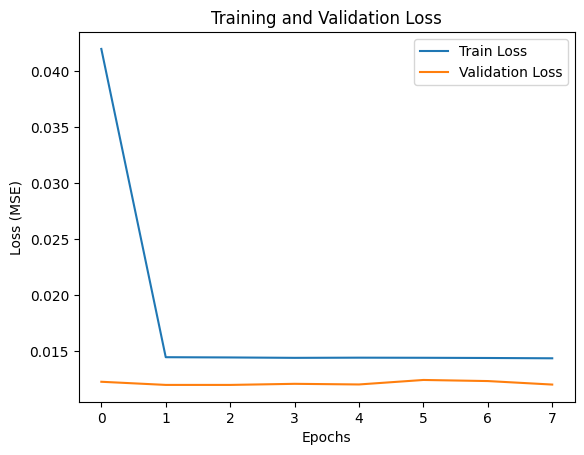

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1056 - mae: 0.1056 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 2/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 3/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 4/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0115 - val_mae: 0.0115
Epoch 5/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0114 - val_mae: 0.0114
Epoch 6/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0114 - val_mae: 0.0114
Epoch 7/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0114 - val_mae: 0.0114
Epoch 8/50
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0114 - val_mae: 0.0114
E

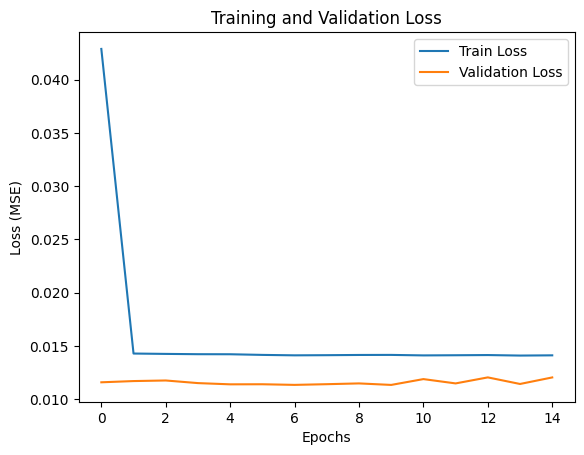

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0860 - mae: 0.0860 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 2/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 3/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 4/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 5/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 6/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 7/50
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0127 - val_mae: 0.0127


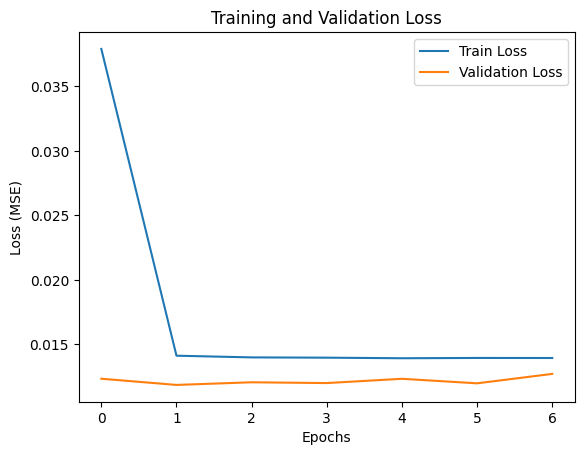

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0895 - mae: 0.0895 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 2/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 3/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 4/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 5/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 6/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 7/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 8/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0127 - val_mae: 0.0127


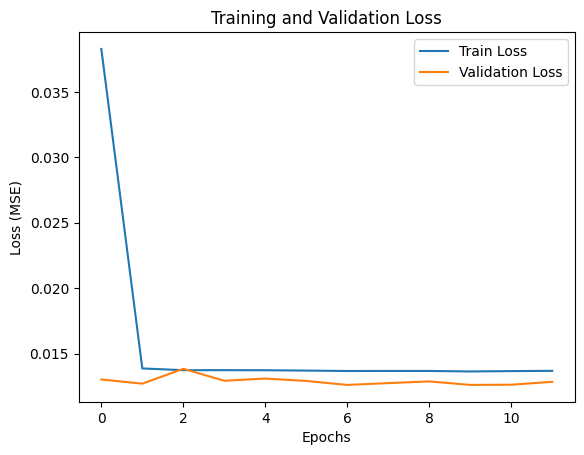

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0597 - mae: 0.0597 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 2/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 3/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 4/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 5/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 6/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 7/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 8/50
2425/2425 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0138 - val_mae: 0.0138
E

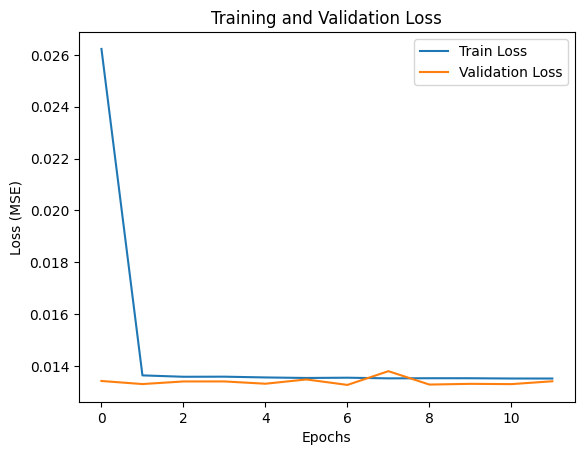

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0993 - mae: 0.0993 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 2/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 3/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 4/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 5/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 6/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 7/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 8/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0140 - val_mae: 0.0140


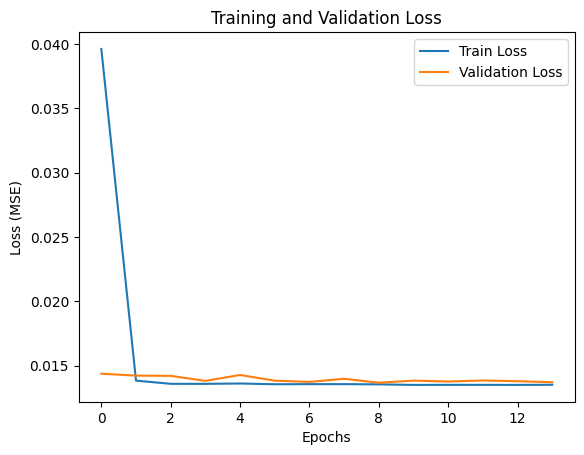

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.0003
RMSE: 0.0167
MAPE: 24362307168.4878
MAE: 0.0114
R2: -0.0157
Correlation: 0.0046
Theil's U: 0.9043




In [158]:
lstm_metrics=[0]*7
for i in range(10):
    
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    # Define input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

    # Create the model
    model = create_unidirectional_lstm(input_shape=input_shape)

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Adjust as needed
        batch_size=128,  # Adjust as needed
        verbose=1,  # 1 shows progress after each epoch
        callbacks=[early_stopping]  # Include early stopping
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Predict returns for the validation set
    y_pred_5 = model.predict(X_test_5)

    y_pred_5 = y_pred_5.flatten()  # Flatten to 1D

    # Calculate metrics
    lstm_metrics[0] += mean_squared_error(y_test_5, y_pred_5)
    lstm_metrics[1] += np.sqrt(mean_squared_error(y_test_5, y_pred_5))
    lstm_metrics[2] += mean_absolute_percentage_error(y_test_5, y_pred_5)
    lstm_metrics[3] += mean_absolute_error(y_test_5, y_pred_5)
    lstm_metrics[4] += r2_score(y_test_5, y_pred_5)
    lstm_metrics[5] += np.corrcoef(y_test_5, y_pred_5)[0, 1]  # Correlation coefficient
    lstm_metrics[6] += theil_u(y_test_5, y_pred_5)

lstm_metrics = [metric / 10 for metric in lstm_metrics]

print_model_metrics(lstm_metrics)

y_pred_5 = y_pred_5.reshape(127, 20)

for i in range(len(list(data_dict[4].keys()))):
    final_lstm_preds[list(data_dict[4].keys())[i]] = y_pred_5[i]

##### Decision Tree Regressor

In [159]:
X_test_5 = X_test_5.reshape(X_test_5.shape[0], -1)
dt_metrics = [0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)

    # Initialize the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=2)

    # Fit the model on the training data
    dt_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_dt = dt_regressor.predict(X_test_5)

    # Calculate metrics
    dt_metrics[0]+= mean_squared_error(y_test_5, y_pred_dt)
    dt_metrics[1]+= np.sqrt(mean_squared_error(y_test_5, y_pred_dt))
    dt_metrics[2]+= mean_absolute_percentage_error(y_test_5, y_pred_dt)
    dt_metrics[3]+= mean_absolute_error(y_test_5, y_pred_dt)
    dt_metrics[4]+= r2_score(y_test_5, y_pred_dt)
    dt_metrics[5]+= np.corrcoef(y_test_5, y_pred_dt)[0, 1]  # Correlation coefficient
    dt_metrics[6]+= theil_u(y_test_5, y_pred_dt)

dt_metrics=[x/10 for x in dt_metrics]

print_model_metrics(dt_metrics)

y_pred_dt = y_pred_dt.reshape(127, 20)

for i in range(len(list(data_dict[4].keys()))):
    final_dt_preds[list(data_dict[4].keys())[i]] = y_pred_dt[i]

# Compute feature importances
importances = dt_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_dt = feature_importance_pairs[:5]# Compute feature importances

MSE: 0.0009
RMSE: 0.0295
MAPE: 311647492483.0996
MAE: 0.0210
R2: -2.1775
Correlation: 0.0053
Theil's U: 0.7180




##### Support Vector Regressor

In [ ]:
svr_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)
    
    svr_regressor = SVR(kernel='rbf', C=0.1, epsilon=0.2)

    # Fit the model on the training data
    svr_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_svr = svr_regressor.predict(X_test_5)

    # Calculate metrics
    svr_metrics[0] += mean_squared_error(y_test_5, y_pred_svr)
    svr_metrics[1] += np.sqrt(mean_squared_error(y_test_5, y_pred_svr))
    svr_metrics[2] += mean_absolute_percentage_error(y_test_5, y_pred_svr)
    svr_metrics[3] += mean_absolute_error(y_test_5, y_pred_svr)
    svr_metrics[4] += r2_score(y_test_5, y_pred_svr)
    svr_metrics[5] += np.corrcoef(y_test_5, y_pred_svr)[0, 1]  # Correlation coefficient
    svr_metrics[6] += theil_u(y_test_5, y_pred_svr)

svr_metrics=[x/10 for x in svr_metrics]

print_model_metrics(svr_metrics)

y_pred_svr = y_pred_svr.reshape(127, 20)

for i in range(len(list(data_dict[4].keys()))):
    final_svr_preds[list(data_dict[4].keys())[i]] = y_pred_svr[i]

MSE: 0.0004
RMSE: 0.0195
MAPE: 162027599692.0976
MAE: 0.0014
R2: -0.0473
Correlation: -0.0026
Theil's U: 0.0730




##### Random Forest Regressor

In [ ]:
rf_metrics=[0]*7

for i in range(10):
    X_train, X_val, y_train, y_val = cross_val_sets[i]
    X_train = X_train.reshape(X_train.shape[0], -1)    
    rf_regressor = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators= 25)

    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_rf = rf_regressor.predict(X_test_5)

    # Calculate metrics
    rf_metrics[0] += mean_squared_error(y_test_5, y_pred_rf)
    rf_metrics[1] += np.sqrt(mean_squared_error(y_test_5, y_pred_rf))
    rf_metrics[2] += mean_absolute_percentage_error(y_test_5, y_pred_rf)
    rf_metrics[3] += mean_absolute_error(y_test_5, y_pred_rf)
    rf_metrics[4] += r2_score(y_test_5, y_pred_rf)
    rf_metrics[5] += np.corrcoef(y_test_5, y_pred_rf)[0, 1]  # Correlation coefficient
    rf_metrics[6] += theil_u(y_test_5, y_pred_rf)

rf_metrics=[x/10 for x in rf_metrics]

print_model_metrics(rf_metrics)

y_pred_rf = y_pred_rf.reshape(127, 20)

for i in range(len(list(data_dict[4].keys()))):
    final_rf_preds[list(data_dict[4].keys())[i]] = y_pred_rf[i]

# Compute feature importances
importances = rf_regressor.feature_importances_

# Get the top 5 features
feature_importance_pairs = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
top_5_features_rf = feature_importance_pairs[:5]# Compute feature importances

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
MSE: 0.0010
RMSE: 0.0316
MAPE: 474837083814.3709
MAE: 0.0017
R2: -0.1008
Correlation: -0.0014
Theil's U: 0.0712




##### Feature Importance

In [172]:
print("Top 5 features for Decision Tree:")
for feature, importance in top_5_features_dt:
    print(f"{feature}: {importance:.4f}")
print("\nTop 5 features for Random Forest:")
for feature, importance in top_5_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 5 features for Decision Tree:
Exchange_Rate: 0.0554
Return_Lag_5: 0.0175
ROC: 0.0103
MTM6: 0.0098
Daily_Return: 0.0088

Top 5 features for Random Forest:
Exchange_Rate: 0.0490
Return_Lag_5: 0.0170
Return_Lag_4: 0.0125
Day_of_Week: 0.0107
ROC: 0.0102


##### Cluster 5 - Model's Performance

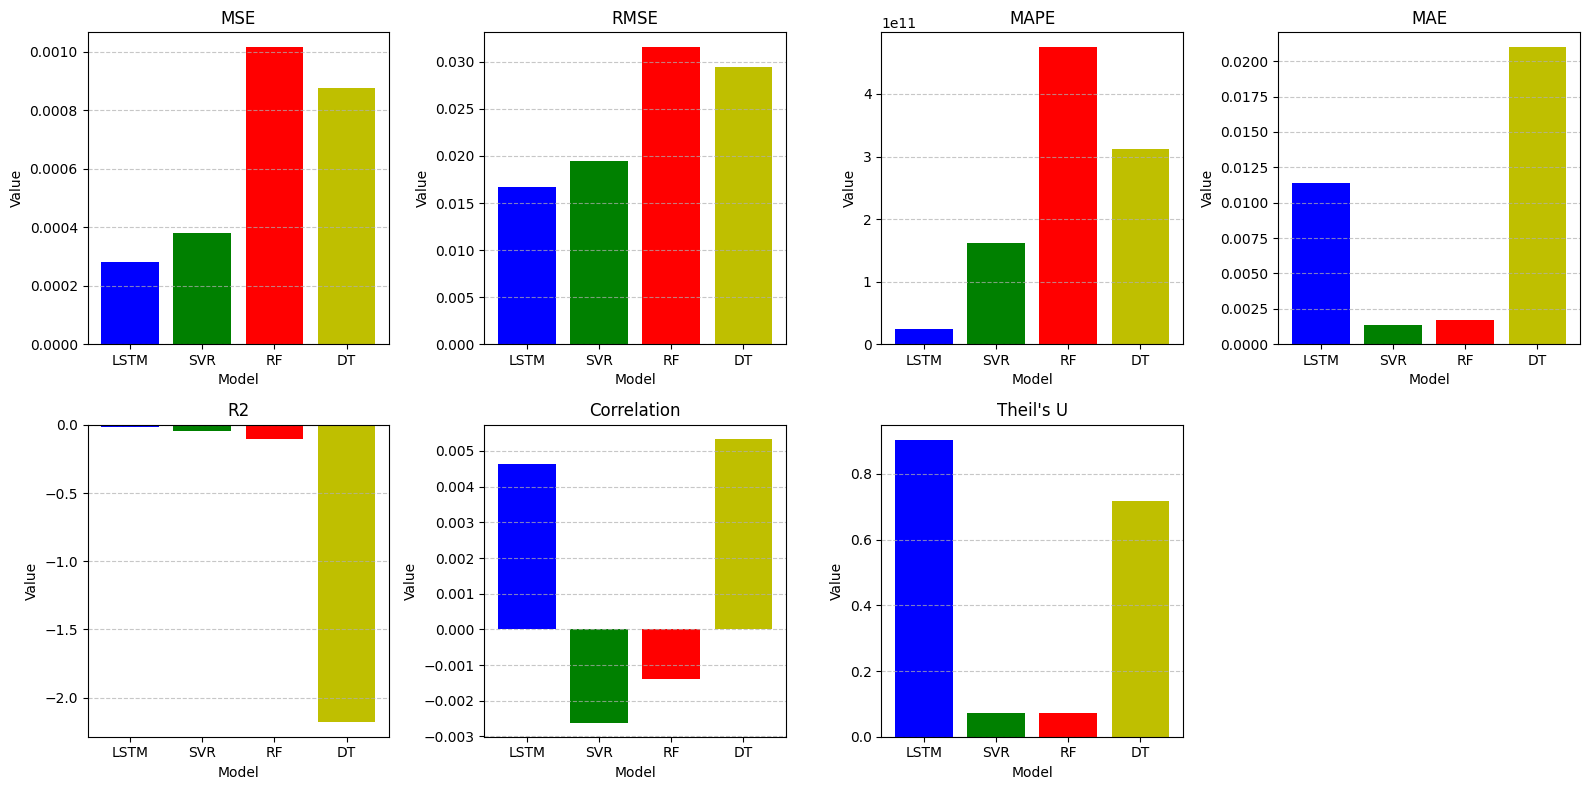

In [173]:
# Metrics for each model
metrics = ["MSE", "RMSE", "MAPE", "MAE", "R2", "Correlation", "Theil's U"]

# Combine metrics into a single array for easier plotting
metrics_values = np.array([lstm_metrics, svr_metrics, rf_metrics, dt_metrics])
# Define data
models = ['LSTM', 'SVR', 'RF', 'DT']

# Create subplots: one for each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust rows/cols as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = metrics_values[:, i]
    ax.bar(models, values, color=['b', 'g', 'r', 'y'])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots (if metrics < 8 in this layout)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Portfolio Optimization

##### Goal: Maximize return, minimize risk

### Negotiation Constraints

- Initial Amount: 10000 USD
- Maximum volume to buy: 100 stocks per day
- Operation cost: 1 USD

Sharpe ratio is widely used in finance to evaluate the performance of an investment or portfolio because it provides a simple and effective way to measure risk-adjusted returns.

The invester_profile parameter is used to adjust the denominator, which accounts for the risk aversion of the investor. A higher invester_profile would imply lower risk tolerance, resulting in a more conservative Sharpe ratio.

By adjusting the denominator with the invester_profile value, the function makes the Sharpe ratio more sensitive to the investor’s risk preferences, providing a more accurate reflection of the risk-adjusted performance given the investor’s profile.

- Risk Averse Investor -> 1.5

- Moderate Investor -> 1.00

- Greedy Investor -> 0.5

In [178]:
def calculate_sharpe_ratio(returns, allocation, risk_free_rate=0.04, invester_profile=1):

    weighted_returns=[allocation[i]*returns[i] for i in range(len(returns))]

    # Calculate the excess returns
    excess_returns = np.sum(weighted_returns)/100 - risk_free_rate
    std_excess_return = np.std(weighted_returns)
    
    # Calculate the Sharpe ratio
    sharpe_ratio = excess_returns / (std_excess_return*invester_profile)
    sum=0
    for i in range(len(allocation)):
        sum+=allocation[i]**2
    sharpe_ratio*=(1-sum)
    return sharpe_ratio

In [179]:
def print_allocation(allocation,keys):
    for i in range(len(allocation)):
        if allocation[i] > 0:
            print(f"{keys[i]}: {allocation[i]}")

#### Monte Carlo Approach

In [222]:
def monte_carlo_search(expected_returns, current_stocks , investor_profile=1, num_simulations=10000, exploration_factor=0.3):
    # Number of companies
    num_companies = len(expected_returns)

    # Initialize variables to track the best result
    best_allocation = None
    best_return = float('-inf')
    best_risk = float('-inf')

    # Maintain a list of promising allocations
    promising_allocations = []

    # Monte Carlo search
    for simulation in range(num_simulations):
        if promising_allocations and random.random() > exploration_factor:
            # Exploit: Focus on promising solutions
            base_allocation = random.choice(promising_allocations)
            allocation = np.random.multinomial(100, base_allocation / np.sum(base_allocation))
        else:
            # Explore: Generate a completely random allocation
            allocation = np.random.multinomial(100, [1/num_companies] * num_companies)

        # Calculate the expected return and risk for this allocation
        total_return = sum(allocation[i] * expected_returns[i] for i in range(num_companies))

        transaction_cost_penalty = np.sum(np.abs(allocation - current_stocks)) * 0.1

        risk = calculate_sharpe_ratio(expected_returns, allocation, invester_profile=investor_profile)
        risk -= transaction_cost_penalty
        # Update the best allocation if this one is better
        if risk > best_risk:
            best_allocation = allocation
            best_return = total_return
            best_risk = risk

        # Track promising allocations
        if total_return >= best_return * 0.9:  # Retain near-optimal solutions
            promising_allocations.append(allocation / np.sum(allocation))

    # Return the best allocation and its metrics
    return best_allocation, best_return, best_risk

##### Genetic Algorithms

In [223]:
def genetic_algorithm_search(expected_returns, investor_profile=1, num_generations=1000, population_size=1000, mutation_rate=0.02):
    num_companies = len(expected_returns)
    
    # Initialize population with integer allocations
    population = np.zeros((population_size, num_companies), dtype=int)
    for i in range(population_size):
        allocation = np.random.multinomial(100, [1/num_companies] * num_companies)
        population[i] = allocation
    
    best_allocation = None
    best_return = float('-inf')
    best_risk = float('-inf')
    
    for generation in range(num_generations):
        # Calculate fitness (Sharpe ratio) for each individual
        fitness = np.array([calculate_sharpe_ratio(expected_returns, ind, invester_profile=investor_profile) for ind in population])
        
        # Remove NaNs and zero-fitness allocations
        valid_fitness_indices = ~np.isnan(fitness) & (fitness > 0)
        population = population[valid_fitness_indices]
        fitness = fitness[valid_fitness_indices]
        
        # Record the best allocation
        idx = np.argmax(fitness)
        if fitness[idx] > best_risk:
            best_allocation = population[idx]
            best_return = np.sum(best_allocation * expected_returns)
            best_risk = fitness[idx]
        
        # Check if we have any valid fitness values left
        if np.sum(fitness) == 0:
            break
        
        # Selection: Roulette wheel selection
        selected_indices = np.random.choice(range(len(fitness)), size=population_size, p=fitness/fitness.sum())
        selected_population = population[selected_indices]
        
        # Crossover
        next_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected_population[i], selected_population[i + 1]
            # Single-point crossover
            crossover_point = np.random.randint(1, num_companies - 1)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            
            # Ensure sum is 100 by rounding and adjusting
            child1 = np.round(child1 / np.sum(child1) * 100).astype(int)
            child2 = np.round(child2 / np.sum(child2) * 100).astype(int)
            
            # Re-normalize if the sum is not 100
            child1 = np.clip(child1, 0, 100) # Ensure non-negative allocations
            child2 = np.clip(child2, 0, 100) # Ensure non-negative allocations
            
            next_population.append(child1)
            next_population.append(child2)
        
        # Mutation
        for child in next_population:
            if random.random() < mutation_rate:
                # Randomly choose a stock and adjust its allocation
                mutation_index = np.random.randint(num_companies)
                child[mutation_index] += random.choice([-1, 1]) # Add or subtract 1 to enforce integer constraint
                # Re-normalize after mutation
                child = np.round(child / np.sum(child) * 100).astype(int)
                # Ensure sum is 100 and non-negative
                child = np.clip(child, 0, 100)
            
        # Update population
        population = np.array(next_population)
    
    return best_allocation, best_return, best_risk

#### Portfolio Metrics

- Final Portfolio Value
- Cumulative Return
- Total Fees Paid
- Total Revenue from Selling
- Total Expenditure on Buying
- Max Drawdown
- Portfolio Volatility
- Final Holdings

### Results

In [262]:
def calculate_final_results(stock_volumes, stock_prices):
    # Validate input
    if len(stock_volumes) != 20 or len(stock_prices) != 20:
        raise ValueError("There must be exactly 20 arrays for stock volumes and stock prices.")

    for day in range(20):
        if len(stock_volumes[day]) != 410 or len(stock_prices[day]) != 410:
            raise ValueError("Each array must have exactly 410 elements.")

    # Initial amount of money
    cash = 10000

    # Initialize current holdings (volumes of stocks we own)
    current_holdings = [0] * 410

    # Metrics to track
    total_fees = 0
    total_revenue = 0
    total_expenditure = 0
    daily_portfolio_values = []
    max_portfolio_value = 10000  # Start with initial cash
    max_drawdown = 0

    for day in range(20):
        for company in range(410):
            desired_volume = stock_volumes[day][company]  # Desired volume for the current day
            current_volume = current_holdings[company]    # Current volume held

            # Calculate the difference to determine buy/sell amount
            volume_difference = desired_volume - current_volume

            # Update cash for buying/selling stocks
            if volume_difference > 0:
                # Buying stocks
                cost = volume_difference * stock_prices[day][company]
                fee = volume_difference
                cash -= (cost + fee)
                total_expenditure += cost
                total_fees += fee
            elif volume_difference < 0:
                # Selling stocks
                revenue = -volume_difference * stock_prices[day][company]
                fee = -volume_difference
                cash += (revenue - fee)
                total_revenue += revenue
                total_fees += fee

            # Update current holdings
            current_holdings[company] = desired_volume

        # Calculate portfolio value at the end of the day
        portfolio_value = cash + sum(current_holdings[company] * stock_prices[day][company] for company in range(410))
        daily_portfolio_values.append(portfolio_value)

        # Update max portfolio value and drawdown
        max_portfolio_value = max(max_portfolio_value, portfolio_value)
        drawdown = max_portfolio_value - portfolio_value
        max_drawdown = max(max_drawdown, drawdown)

    # Final portfolio value
    final_portfolio_value = cash + sum(current_holdings[company] * stock_prices[-1][company] for company in range(410))

    # Absolute return
    absolute_return = ((final_portfolio_value - 10000) / 10000)

    # Portfolio volatility (standard deviation of daily portfolio values)
    average_portfolio_value = sum(daily_portfolio_values) / len(daily_portfolio_values)
    portfolio_volatility = (sum((value - average_portfolio_value) ** 2 for value in daily_portfolio_values) / len(daily_portfolio_values)) ** 0.5
    metrics=[final_portfolio_value, absolute_return, total_fees, total_revenue, total_expenditure, max_drawdown, portfolio_volatility]
    # Print metrics
    print("Final Portfolio Value:", final_portfolio_value)
    print("Cumulative Return:", absolute_return)
    print("Total Fees Paid:", total_fees)
    print("Total Revenue from Selling:", total_revenue)
    print("Total Expenditure on Buying:", total_expenditure)
    print("Max Drawdown:", max_drawdown)
    print("Portfolio Volatility:", portfolio_volatility)
    print("Final Holdings:", current_holdings)
    return metrics

In [225]:
# Function to run the optimization and model
def run_optimization_and_model(optimization_method, model_name, expected_returns, current_stocks, investor_profile):
    daily_results = []
    for day in range(20):
        expected_returns_day = expected_returns[day]
        if investor_profile == 'Risk Averse Investor':
            investor_prof=1.5
        if investor_profile == 'Moderate Investor':
            investor_prof=1
        if investor_profile == 'Greedy Investor':
            investor_prof=0.5
        if optimization_method == 'Monte Carlo':
            best_allocation, best_return, best_risk = monte_carlo_search(expected_returns_day, current_stocks, investor_profile=investor_prof)
        elif optimization_method == 'Genetic Algorithms':
            best_allocation, best_return, best_risk = genetic_algorithm_search(expected_returns_day, investor_profile=investor_prof)
        
        daily_results.append({
            "day": day + 1,
            "best_allocation": best_allocation,
            "best_return": best_return,
            "best_risk": best_risk
        })
        
        current_stocks = best_allocation
    
    return daily_results

We employed all combinations of the following techniques and strategies to optimize the portfolio and select the best set of stocks for each day:

1. Optimization Methods: Monte Carlo simulations and Genetic Algorithms.
2. Prediction Models: Long Short-Term Memory (LSTM), Random Forest (RF), Decision Trees (DT), and Support Vector Regression (SVR).
3. Investor Profiles: Risk-Averse Investor, Moderate Investor, and Greedy Investor.

By exploring these combinations, we analyzed and identified the optimal portfolio configurations tailored to different investment strategies and daily market conditions.

In [226]:
# Define the models and optimization methods
models = ['LSTM', 'Random Forest', 'SVM', 'DT']
optimization_methods = ['Genetic Algorithms', 'Monte Carlo']
investor_profile = ['Risk Averse Investor', 'Moderate Investor', 'Greedy Investor']

# Initialize storage for results
results = []

# Simulated expected returns for 20 days (replace with actual data)
expected_returns_svr = [np.array(list(final_svr_preds.values()))[:, day] for day in range(20)]
expected_returns_lstm = [np.array(list(final_lstm_preds.values()))[:, day] for day in range(20)]
expected_returns_rf = [np.array(list(final_rf_preds.values()))[:, day] for day in range(20)]
expected_returns_dt = [np.array(list(final_dt_preds.values()))[:, day] for day in range(20)]

expected_returns_list = [expected_returns_lstm, expected_returns_rf, expected_returns_svr, expected_returns_dt]

# Simulated current stock holdings
current_stocks = [0] * 410

# Loop over each combination of optimization method and model
for optimization_method in optimization_methods:
    for model_name in range(len(models)):
        for investor_profile_name in investor_profile:
            print(f"Running {optimization_method} with {models[model_name]} model - {investor_profile_name}")
            expected_returns = expected_returns_list[model_name]
            # Run the optimization and model
            daily_results = run_optimization_and_model(optimization_method, models[model_name], expected_returns, current_stocks, investor_profile_name)
            
            # Store the results
            results.append({
                "optimization_method": optimization_method,
                "model_name": models[model_name],
                "investor_profile": investor_profile_name,
                "daily_results": daily_results
            })

# Print the results for all combinations
for result in results:
    print(f"Optimization Method: {result['optimization_method']}, Model: {result['model_name']}, Investor Profile: {result['investor_profile']}")
    for daily_result in result['daily_results']:
        print(f"Day {daily_result['day']}:")
        print_allocation(daily_result['best_allocation'], list(final_svr_preds.keys()))
        print("Best Expected Return:", daily_result['best_return'])
        print("Best Risk Value (as Sharpe Ratio):", daily_result['best_risk'])
        print("-")

Running Genetic Algorithms with LSTM model - Risk Averse Investor
Running Genetic Algorithms with LSTM model - Moderate Investor
Running Genetic Algorithms with LSTM model - Greedy Investor
Running Genetic Algorithms with Random Forest model - Risk Averse Investor
Running Genetic Algorithms with Random Forest model - Moderate Investor
Running Genetic Algorithms with Random Forest model - Greedy Investor
Running Genetic Algorithms with SVM model - Risk Averse Investor
Running Genetic Algorithms with SVM model - Moderate Investor
Running Genetic Algorithms with SVM model - Greedy Investor
Running Genetic Algorithms with DT model - Risk Averse Investor
Running Genetic Algorithms with DT model - Moderate Investor
Running Genetic Algorithms with DT model - Greedy Investor
Running Monte Carlo with LSTM model - Risk Averse Investor
Running Monte Carlo with LSTM model - Moderate Investor
Running Monte Carlo with LSTM model - Greedy Investor
Running Monte Carlo with Random Forest model - Risk A

#### Portfolio Metrics for each combination (Model, Optimization Method, Risk Investor Profile)

In [263]:
stock_prices = np.load('stock_prices.npy')
metrics_data = []
for result in results:
    print(f"Optimization Method: {result['optimization_method']}, Model: {result['model_name']}, Investor Profile: {result['investor_profile']}")
    stock_volumes = [daily_result['best_allocation'] for daily_result in result['daily_results']]
    metrics=calculate_final_results(stock_volumes, stock_prices)
    metrics_data.append({
        'Optimization Method': result['optimization_method'],
        'Model Name': result['model_name'],
        'Investor Profile': result['investor_profile'],
        'Final Portfolio Value': metrics[0],
        'Cumulative Return': metrics[1],
        'Total Fees Paid': metrics[2],
        'Total Revenue from Selling': metrics[3],
        'Total Expenditure on Buying': metrics[4],
        'Max Drawdown': metrics[5],
        'Portfolio Volatility': metrics[6],
    })
    print("-")

Optimization Method: Genetic Algorithms, Model: LSTM, Investor Profile: Risk Averse Investor
Final Portfolio Value: 6192.830518722534
Cumulative Return: -0.3807169481277466
Total Fees Paid: 3683
Total Revenue from Selling: 275883.057847023
Total Expenditure on Buying: 301816.9754104614
Max Drawdown: 3807.169481277466
Portfolio Volatility: 1116.8609810386508
Final Holdings: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,

In [264]:
df = pd.DataFrame(metrics_data)
df

,Optimization Method,Model Name,Investor Profile,Final Portfolio Value,Cumulative Return,Total Fees Paid,Total Revenue from Selling,Total Expenditure on Buying,Max Drawdown,Portfolio Volatility
0,Genetic Algorithms,LSTM,Risk Averse Investor,6192.830519,-0.380717,3683,275883.057847,301816.975410,3807.169481,1116.860981
1,Genetic Algorithms,LSTM,Moderate Investor,6656.811348,-0.334319,3720,350906.170947,372147.759459,3343.188652,890.933758
2,Genetic Algorithms,LSTM,Greedy Investor,6570.872549,-0.342913,3688,322051.766658,344382.953434,3429.127451,933.102137
3,Genetic Algorithms,Random Forest,Risk Averse Investor,6563.612604,-0.343639,3718,312096.750172,332085.573223,3436.387396,941.028192
4,Genetic Algorithms,Random Forest,Moderate Investor,7090.183001,-0.290982,3638,317926.177864,343583.528867,2909.816999,811.756034
5,Genetic Algorithms,Random Forest,Greedy Investor,7306.326782,-0.269367,3634,351656.147866,361497.624127,2990.490772,837.473647
6,Genetic Algorithms,SVM,Risk Averse Investor,6743.161967,-0.325684,3627,339027.638703,351519.346762,3256.838033,873.932442
7,Genetic Algorithms,SVM,Moderate Investor,5878.432885,-0.412157,3587,364992.281700,392907.545325,4121.567115,1180.992355
8,Genetic Algorithms,SVM,Greedy Investor,6514.621608,-0.348538,3635,340622.384162,369361.257135,3498.942897,1050.231390
9,Genetic Algorithms,DT,Risk Averse Investor,7230.522248,-0.276948,3682,361256.748295,387527.533868,2769.477752,760.475009


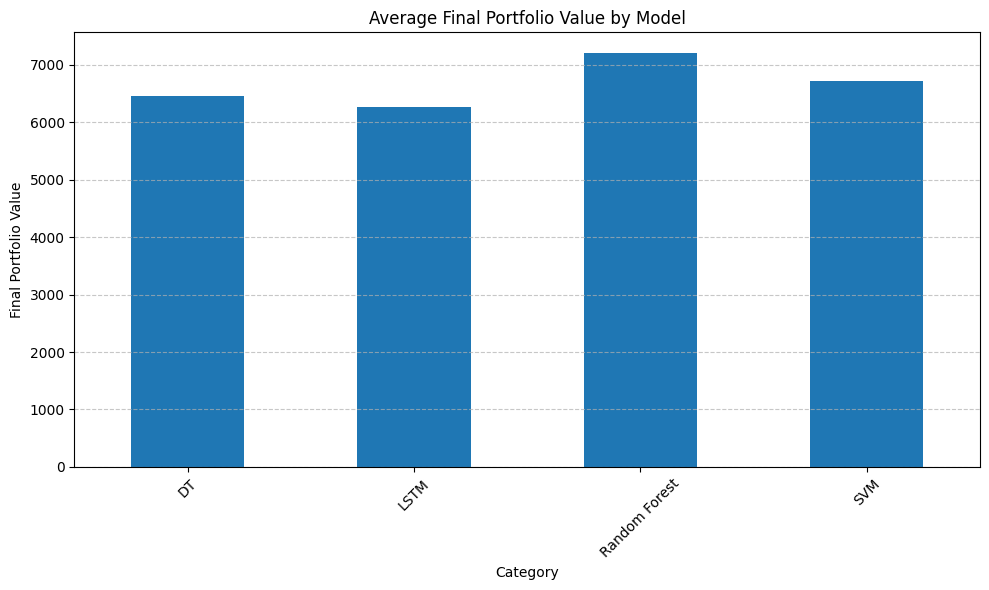

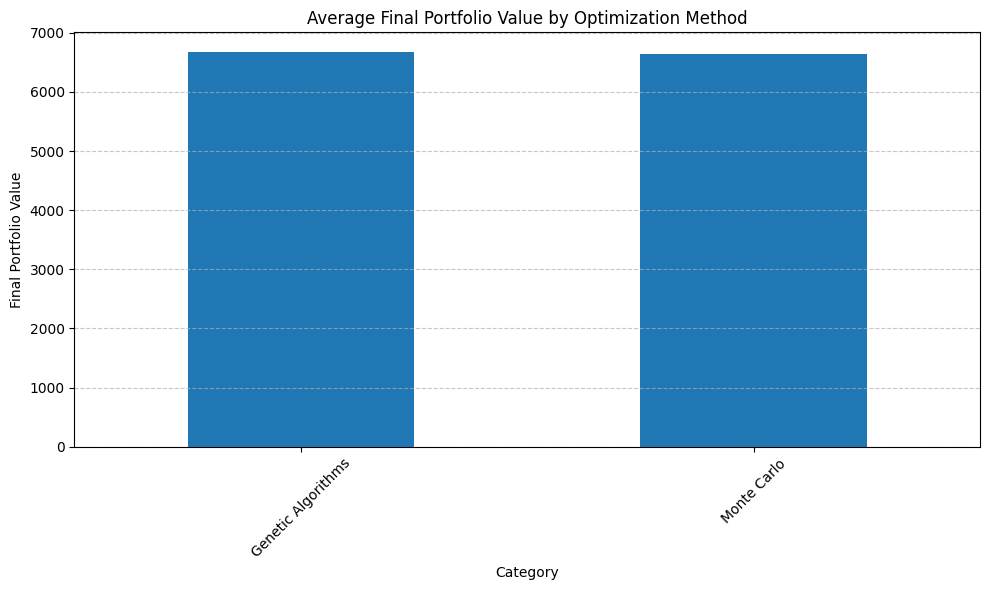

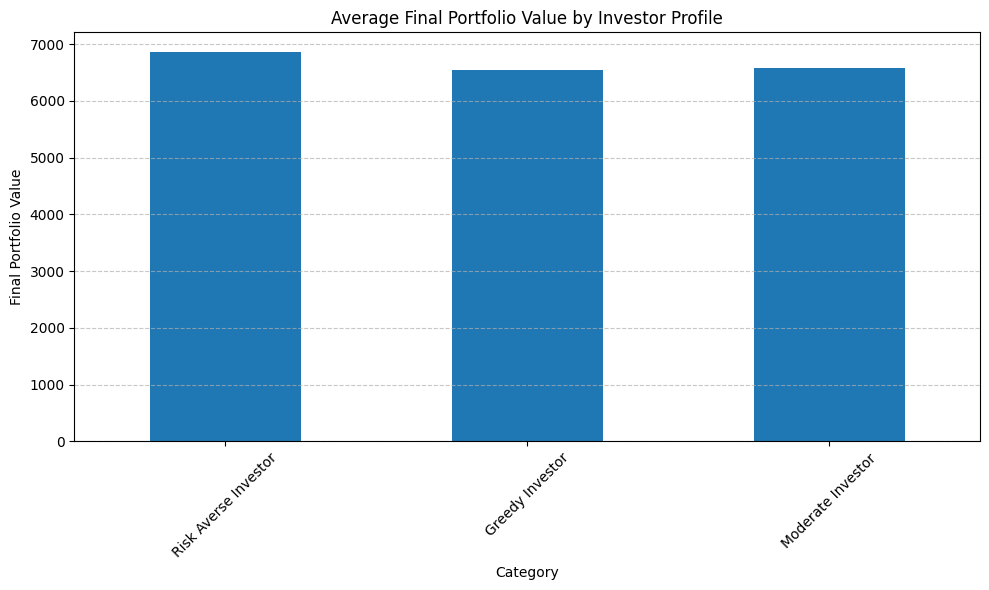

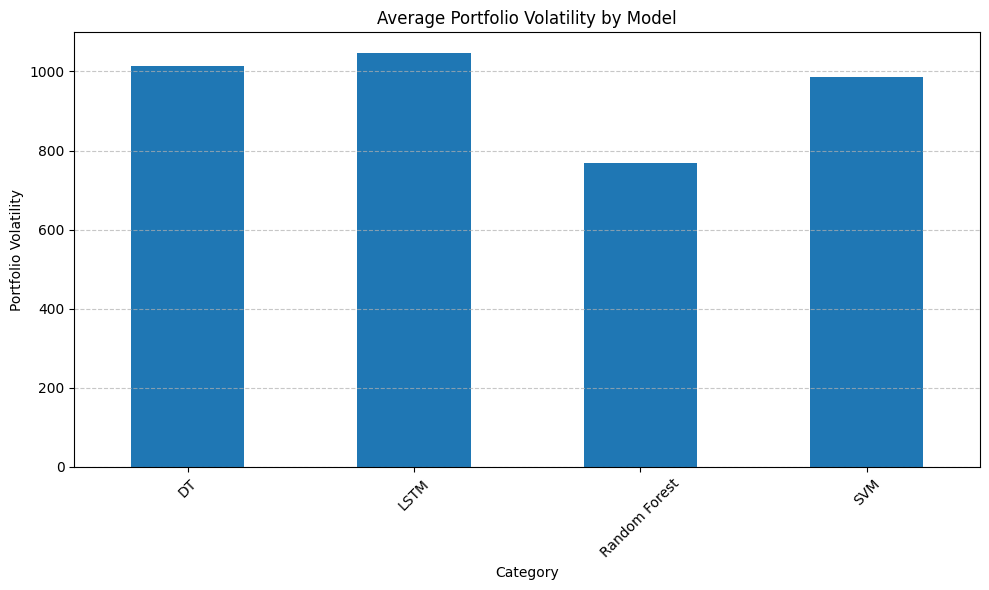

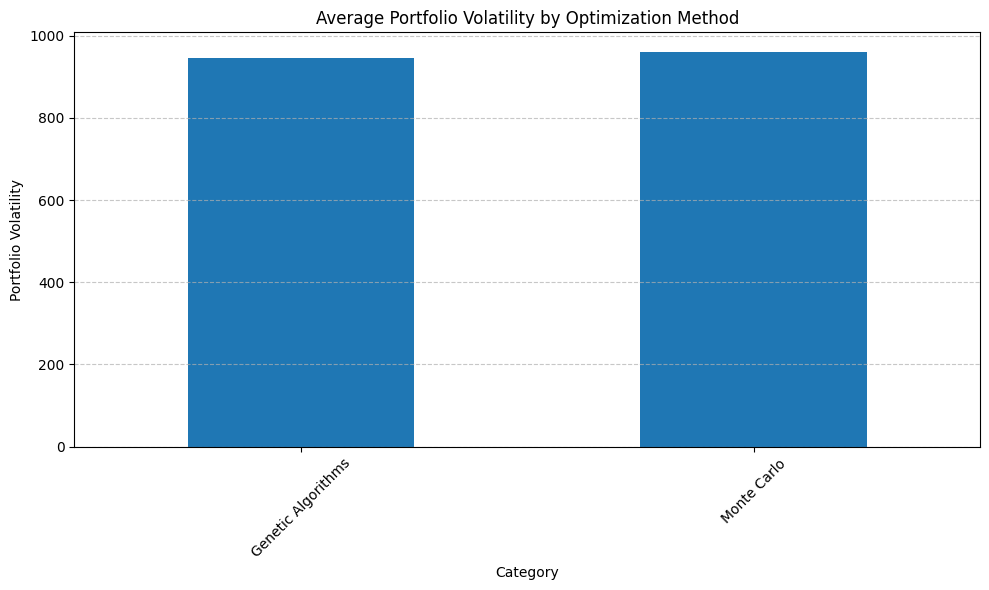

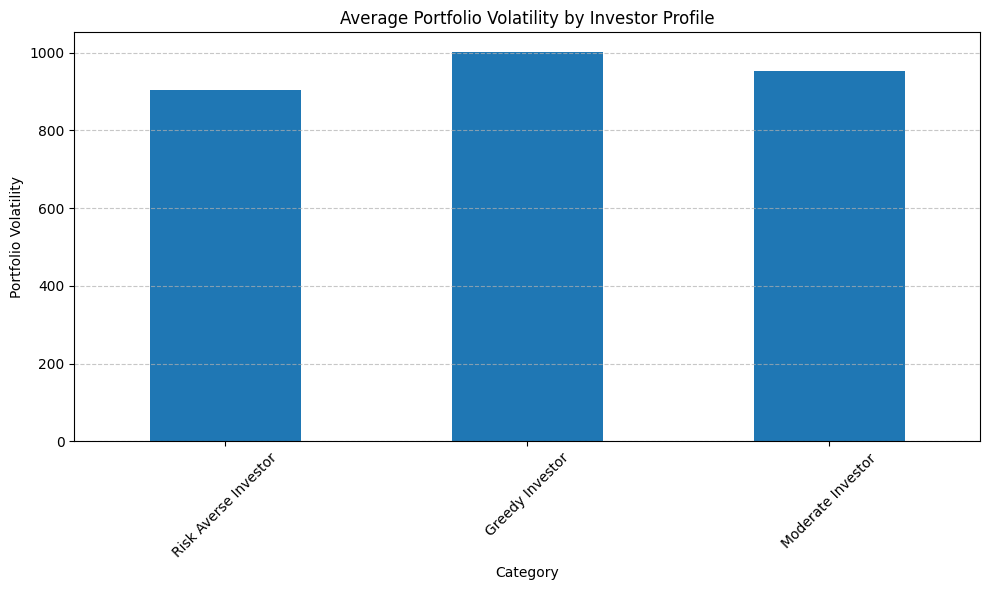

<Figure size 640x480 with 0 Axes>

In [258]:
numeric_columns = df.select_dtypes(include=np.number).columns
avg_by_model = df.groupby('Model Name')[numeric_columns].mean()
avg_by_optimization = df.groupby('Optimization Method')[numeric_columns].mean()
avg_by_profile = df.groupby('Investor Profile')[numeric_columns].mean()

# Plotting function
def plot_bar(data, title, ylabel, xlabel='Category', figsize=(10, 6)):
    data.plot(kind='bar', figsize=figsize)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot Average Final Portfolio Value by Model
plot_bar(avg_by_model['Final Portfolio Value'], 
         title='Average Final Portfolio Value by Model',
         ylabel='Final Portfolio Value')

# Plot Average Final Portfolio Value by Optimization Method
plot_bar(avg_by_optimization['Final Portfolio Value'], 
         title='Average Final Portfolio Value by Optimization Method',
         ylabel='Final Portfolio Value')

# Plot Average Final Portfolio Value by Investor Profile
plot_bar(avg_by_profile['Final Portfolio Value'], 
         title='Average Final Portfolio Value by Investor Profile',
         ylabel='Final Portfolio Value')

# Plot Average Portfolio Volatility by Model
plot_bar(avg_by_model['Portfolio Volatility'], 
         title='Average Portfolio Volatility by Model',
         ylabel='Portfolio Volatility')

# Plot Average Portfolio Volatility by Optimization Method
plot_bar(avg_by_optimization['Portfolio Volatility'], 
         title='Average Portfolio Volatility by Optimization Method',
         ylabel='Portfolio Volatility')

plot_bar(avg_by_profile['Portfolio Volatility'], 
         title='Average Portfolio Volatility by Investor Profile',
         ylabel='Portfolio Volatility')


plt.tight_layout()
plt.show()

### Conclusions

In our work comparing different models for stock market prediction—specifically, Long Short-Term Memory (LSTM), Support Vector Regression (SVR), Decision Trees (DT), and Random Forest—Random Forest emerged as the superior model. Its ability to deliver accurate and consistent predictions across various datasets made it the best performer. Notably, there was no significant difference observed between the effectiveness of Monte Carlo and Genetic Algorithm for parameter tuning, suggesting that both methods were equally viable for optimizing the models.

Additionally, the investigation into risk management strategies revealed that adopting a risk-averse approach resulted in the lowest volatility, with the greedy strategy leading to the highest. This finding highlights the importance of aligning the chosen model and strategy with the investor’s risk tolerance, as well as the need for careful consideration when balancing potential returns and associated risks in stock market predictions.

### References

##### Books:

Jacinta Chan (Year). Automation of Trading Machines for Traders.

Rolf Schlotmann and Moritz Czubatinski (Year). Technical Analysis Masterclass.

Rubén Villahermosa (Year). The Wyckoff Methodology in Depth.

##### Articles:

Lim, M., & Zohren, S. (2021). Time-Series Forecasting with Deep Learning: A Survey. Highlighted the integration of deep learning models in financial forecasting, providing a broad perspective on state-of-the-art methodologies.

Wei Bao, Jun Yue, and Yulei Rao. A deep learning framework for financial time series using stacked autoencoders and long-short term memory. PloS one, 12(7):e0180944, 2017

Jigar Patel, Sahil Shah, Priyank Thakkar, and Ketan Kotecha. Predicting stock and stock price index movement using trend deterministic data preparation and machine learning techniques. Expert systems with applications, 42(1):259–268, 2015

Chi-Ming Lin and Mitsuo Gen. Multi-criteria human resource allocation for solving multistage combinatorial optimization problems using multiobjective hybrid genetic algorithm. Expert Systems with Applications, 34(4):2480–2490, 2008.

Brockwell, P. J., & Davis, R. A. (2002). Introduction to Time Series and Forecasting (2nd ed.). Springer. Served as a foundational text for understanding time series methods and their applications in financial forecasting.

Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer. Provided a detailed exploration of Monte Carlo methods in finance, enhancing risk management and pricing models.